# Notebook to generate results in:
_The Antarctic crust and upper mantle: a flexible 3D model and software framework for interdisciplinary research_
---
T. Stål

University of Tasmania

---
This notebook contains snippets of the code to in an inforamtive way generate results and figures included in the main article. Short comments are included for guideance. 

Some placeholders are included, hence, the results might differ slightly from publisghed figures. As links to data and packages are changing, the notebook might not be totally reproducible, however I hope that the provided code can still be useful in similar applications and updates. 


In [1]:
# With auto reload, the notebook is updated whan the code in imported modules are updated
%load_ext autoreload
%autoreload 2

In [2]:
# Import standard packages alla avilible in conda or by pip. 
import os
import glob 
import re
import pickle

import pandas as pd
import numpy as np
import xarray as xr
import pyproj as proj

from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

from scipy.io import loadmat
from scipy import stats, interpolate
from scipy.ndimage import gaussian_filter
from scipy.stats import gaussian_kde

import seaborn as sns # only used for Fig 7

Modules provided with the notebook are _agrid_ (Stål and Reading, 2020) and _SCM6_ , perceptually linear colormaps from Shephard and Crameri (2020).

In [3]:
# SCM6 is availible from pip, conda or directely from http://www.fabiocrameri.ch/colourmaps.php
import SCM6

In [4]:
# Install agrid as e.g:
#! pip install agrid -q

# or download module and link to relative path: 
#import sys
#sys.path.append('..')

from agrid.grid import Grid
from agrid.acc import download

#useful prefix
km = 1000 #int
milli = 1/1e3
micro = 1/1e6

Download all datasets used to a data directory:

In [30]:
# Make data directory, if doesn't exist, and set up your data_path:
! mkdir -p ../../data
! mkdir -p fig

data_path = '../../data'

In [31]:
# Download if doesn't excist in data directory
# The method returns as default a list of unpacked files
an_files = download('http://www.seismolab.org/model/antarctica/lithosphere/AN1-S_depth_grd.tar.gz',
         data_path + '/An/AN1-S_depth_grd.tar.gz')

# Get depths from An model
an_files.sort(key=str.lower)
an_depths_float = [km*float(re.findall(r"[-+]?\d*\.\d+|\d+", _)[-1])
                             for _ in an_files] #regex to get number from file names

print(an_depths_float) #in SI unit: metre

Content:  application/x-gzip
File ../../data/An/AN1-S_depth_grd.tar.gz already exists.
[0.0, 2500.0, 5000.0, 7500.0, 10000.0, 12500.0, 15000.0, 17500.0, 20000.0, 25000.0, 30000.0, 35000.0, 40000.0, 45000.0, 50000.0, 55000.0, 60000.0, 65000.0, 70000.0, 75000.0, 80000.0, 85000.0, 90000.0, 95000.0, 100000.0, 105000.0, 110000.0, 115000.0, 120000.0, 125000.0, 130000.0, 135000.0, 140000.0, 145000.0, 150000.0, 155000.0, 160000.0, 165000.0, 170000.0, 180000.0, 190000.0, 200000.0, 210000.0, 220000.0, 230000.0, 240000.0, 250000.0, 275000.0, 300000.0, 325000.0, 350000.0]


We use the extracted values as depth slices to generate two agrid grid models, one for continental Antarctica, and one for Wilkes Subglacial Basin. 

In [32]:
ant = Grid(crs=3031, 
           res = [25*km, 25*km], 
           extent=[-2800*km, 2800*km, -2800*km, 2800*km], 
           depths= an_depths_float)

wsb = Grid(crs=3031, 
           res = [20*km, 20*km], 
           extent=[180*km, 2500*km, -2500*km, -180*km], 
           depths= an_depths_float)

We also wish to generate a colormap with colors defined by international Commition for Stratigraphy, using Strat code (Stål, 2019). However as this is not really needed, we handle esceptions by using another colormap:

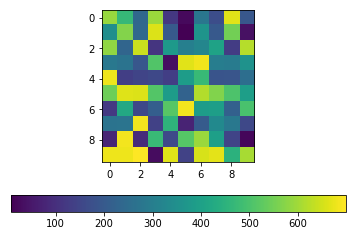

In [33]:
try:
    import matplotlib.colors
    colors = pd.read_json('ChronostratChart2018-08_rgb.json', lines=True)
    ages = pd.read_json('ChronostratChart2018-08.json', lines=True)
    cols = list(colors['Era'])
    ags = [0] + list(ages['Start']) 

    for i, col in enumerate(cols):
        if col is None:
            cols[i] = [0.,0.,0.,0.]
        else:
            cols[i] = col.split('/') + [255]
            cols[i] = [float(c)/255 for c in cols[i]]
        
    cmap_strat, norm_strat = matplotlib.colors.from_levels_and_colors(ags, cols)
except:
    cmap_strat = 'viridis'
    norm_strat = None

dat = 700 * np.random.random((10, 10))

fig, ax = plt.subplots()
im = ax.imshow(dat, cmap=cmap_strat, norm=norm_strat, interpolation='none')
fig.colorbar(im, ax=ax, orientation='horizontal')
plt.show()

The depth slices provided by An might not be optimal, we set an additional Z axis for the continental grid:

In [34]:
z_new = [0, 8, 16, 25, 30, 35, 40, 45, 50, 75, 100, 150, 200, 300]
ant.ds.coords['Z_NEW'] = np.array(z_new)*km

We download a polygon vector file and a compressed set of raster files:

In [37]:
download('https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/physical/ne_10m_land.zip', 
        data_path + '/NE/ne_10m_land.zip', 
        meta_dict={'Type' : 'Land Polygons'})


bedmap_data = 'bedmap2_tiff.zip'
bedmap_url = 'https://secure.antarctica.ac.uk/data/bedmap2/'
bedmap_files = download(bedmap_url + bedmap_data,
                  data_path +'Bedmap/'+ bedmap_data)


Content:  text/html; charset=UTF-8
File ../../data/NE/ne_10m_land.zip already exists.
Content:  application/zip
File ../../dataBedmap/bedmap2_tiff.zip already exists.


LAND is a polygon that defines coastline/grounding line. We also read values from Bedmap2 raster files:

In [38]:
for grid in [ant, wsb]:
    grid.ds['LAND'] = (('Y', 'X'), grid.assign_shape(data_path + '/NE/ne_10m_land.shp', 
                                               'scalerank', map_to_int = False, burn_val = 1) )
    grid.ds['BED'] = (('Y', 'X'), 
                grid.read_raster(data_path + '/Bedmap/bedmap2_tiff/bedmap2_bed.tif', no_data = 32767.) )

    grid.ds['SURFACE'] = (('Y', 'X'), 
                grid.read_raster(data_path + '/Bedmap/bedmap2_tiff/bedmap2_surface.tif', no_data = 32767.) )
    
    
    grid.ds['ICE'] = grid.ds['LAND'] * (grid.ds['SURFACE'] - grid.ds['BED'])
    

We also include a global tomography model, just for ant, it has a different set of depth slices:

In [39]:
smean_url = 'http://www-udc.ig.utexas.edu/external/becker/ftp/smean2_grd.tgz'
smean_files = download(smean_url,data_path + '/smean2/smean2_grd.tgz')

pmean_url = 'http://www-udc.ig.utexas.edu/external/becker/ftp/pmean_grd.tgz'
pmean_files = download(pmean_url,data_path + '/pmean/pmean_grd.tgz')

prem_url = 'http://ds.iris.edu/files/products/emc/data/PREM/PREM_ANISOTROPIC.csv'
prem_file = data_path + '/earth_models/PREM_ANISOTROPIC.csv'
smean_files = download(prem_url,prem_file)

Content:  application/x-gzip
File ../../data/smean2/smean2_grd.tgz already exists.
Content:  application/x-gzip
File ../../data/pmean/pmean_grd.tgz already exists.
Content:  text/csv
File ../../data/earth_models/PREM_ANISOTROPIC.csv already exists.


In [40]:
smean_depths = km * np.loadtxt(data_path + '/smean2/depths.dat')
max_depth = np.max(smean_depths)

depths = km * np.array([*range(20, 1000, 20)] + [*range(1000, int(max_depth)//km, 50)])

prem_d, prem_vsv, prem_vsh = km * np.loadtxt(prem_file, 
                              delimiter = ',', 
                              usecols = [1, 5, 6],
                              unpack=True)

prem_vsv = prem_vsv[prem_d < max_depth]
prem_vsh = prem_vsh[prem_d < max_depth]
prem_d = prem_d[prem_d < max_depth]

ant.ds.coords['SMEAN_Z'] = smean_depths[::-1]

print(ant.ds.coords['SMEAN_Z'])

<xarray.DataArray 'SMEAN_Z' (SMEAN_Z: 58)>
array([  25000.,   75000.,  125000.,  175000.,  225000.,  275000.,  325000.,
        375000.,  425000.,  475000.,  525000.,  575000.,  625000.,  675000.,
        725000.,  775000.,  825000.,  875000.,  925000.,  975000., 1025000.,
       1075000., 1125000., 1175000., 1225000., 1275000., 1325000., 1375000.,
       1425000., 1475000., 1525000., 1575000., 1625000., 1675000., 1725000.,
       1775000., 1825000., 1875000., 1925000., 1975000., 2025000., 2075000.,
       2125000., 2175000., 2225000., 2275000., 2325000., 2375000., 2425000.,
       2475000., 2525000., 2575000., 2625000., 2675000., 2725000., 2775000.,
       2825000., 2875000.])
Coordinates:
  * SMEAN_Z  (SMEAN_Z) float64 2.5e+04 7.5e+04 1.25e+05 ... 2.825e+06 2.875e+06


We use read_grid method to import layers to the 3D grid:

In [41]:
smean_array = np.empty((ant.ny, ant.nx, smean_depths.size))

for i, a in enumerate(smean_depths):
    print(a//km, end=', ')
    index_name = smean_depths//km - i # Get right file name for each depth
    fname = data_path + '/smean2/dvs.%s.grd'%(i+1)
    if os.path.isfile(fname):
        smean_array[:,:,i] = ant.read_grid(fname, xyz = ('lon','lat','z'), set_center = True, pad_around = True)
        
smean_array /= 100. # percent to decimal

2875.0, 2825.0, 2775.0, 2725.0, 2675.0, 2625.0, 2575.0, 2525.0, 2475.0, 2425.0, 2375.0, 2325.0, 2275.0, 2225.0, 2175.0, 2125.0, 2075.0, 2025.0, 1975.0, 1925.0, 1875.0, 1825.0, 1775.0, 1725.0, 1675.0, 1625.0, 1575.0, 1525.0, 1475.0, 1425.0, 1375.0, 1325.0, 1275.0, 1225.0, 1175.0, 1125.0, 1075.0, 1025.0, 975.0, 925.0, 875.0, 825.0, 775.0, 725.0, 675.0, 625.0, 575.0, 525.0, 475.0, 425.0, 375.0, 325.0, 275.0, 225.0, 175.0, 125.0, 75.0, 25.0, 

In [42]:
pmean_depths = km * np.loadtxt(data_path + '/pmean/depths.dat')
max_depth = np.max(pmean_depths)

pmean_depths = km * np.array([*range(20, 1000, 20)] + [*range(1000, int(max_depth)//km, 50)])

ant.ds.coords['PMEAN_Z'] = pmean_depths

print(pmean_depths)

[  20000   40000   60000   80000  100000  120000  140000  160000  180000
  200000  220000  240000  260000  280000  300000  320000  340000  360000
  380000  400000  420000  440000  460000  480000  500000  520000  540000
  560000  580000  600000  620000  640000  660000  680000  700000  720000
  740000  760000  780000  800000  820000  840000  860000  880000  900000
  920000  940000  960000  980000 1000000 1050000 1100000 1150000 1200000
 1250000 1300000 1350000 1400000 1450000 1500000 1550000 1600000 1650000
 1700000 1750000 1800000 1850000 1900000 1950000 2000000 2050000 2100000
 2150000 2200000 2250000 2300000 2350000 2400000 2450000 2500000 2550000
 2600000 2650000 2700000 2750000 2800000]


In [43]:
pmean_array = np.empty((ant.ny, ant.nx, pmean_depths.size))

for i, a in enumerate(pmean_depths):
    print(a//km, end=', ')
    index_name = pmean_depths//km - i # Get right file name for each depth
    fname = data_path + '/pmean/dvp.%s.grd'%(i+1)
    if os.path.isfile(fname):
        pmean_array[:,:,i] = ant.read_grid(fname, xyz = ('lon','lat','z'), set_center = True, pad_around = True)
        
pmean_array /= 100 # Percent to decimal

20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480, 500, 520, 540, 560, 580, 600, 620, 640, 660, 680, 700, 720, 740, 760, 780, 800, 820, 840, 860, 880, 900, 920, 940, 960, 980, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000, 2050, 2100, 2150, 2200, 2250, 2300, 2350, 2400, 2450, 2500, 2550, 2600, 2650, 2700, 2750, 2800, 

We assign the generated numpy arrays to the agrid object, using xarray and the native z-axes:

In [44]:
ant.ds['PMEAN'] = (('Y', 'X', 'PMEAN_Z'), pmean_array)
ant.ds['SMEAN'] = (('Y', 'X', 'SMEAN_Z'), smean_array)

Interpolate values to defined depth slices:

In [45]:
ant.ds['PMEAN_I'] = ( ('Y', 'X', 'Z_NEW'), 
                           ant.change_coord(ant.ds['PMEAN'], ant.ds['PMEAN_Z'], ant.ds['Z_NEW'], axis=-1) )


ant.ds['SMEAN_I'] = ( ('Y', 'X', 'Z_NEW'), 
                           ant.change_coord(ant.ds['SMEAN'], ant.ds['SMEAN_Z'], ant.ds['Z_NEW'], axis=-1) )

map_grid is a method to print the grid in map view. A slice through the cube is selected:

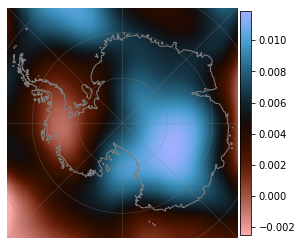

In [46]:
ant.map_grid(ant.ds.SMEAN.sel(SMEAN_Z=175*km), 
             cmap=SCM6.berlin_r, 
             cbar=True, 
             figsize=(4,4))

Using bulk=True, a directory containing files can be imported at once:

In [47]:
for grid in [ant, wsb]:
    an_array, an_depths = grid.read_grid(data_path + '/An/AN1-S_depth_grd/', 
                         xyz = ('x','y','z'),            
                         bulk=True, 
                        depth_factor= km,
                         extension='.grd',
                         return_list = True)

    grid.ds['AN_S1'] = xr.DataArray(an_array,
                  coords=(grid.ds.coords['Y'], grid.ds.coords['X'], grid.ds.coords['Z']),
                dims=('Y', 'X', 'Z'))


In [48]:
# Temperature model:
for grid in [ant, wsb]:
    an_Ts_array, an_Ts_depths = grid.read_grid(data_path + '/An/AN1-Ts_depth_grd/', 
                         xyz = ('x','y','z'), 
                         bulk=True, 
                         depth_factor= km,
                         extension='.grd',
                         return_list = True) 
    grid.ds['AN_TS'] = xr.DataArray(an_Ts_array,
                  coords=(grid.ds.coords['X'], grid.ds.coords['Y'], an_Ts_depths),
                   dims=('Y', 'X', 'Z'))

In [49]:
# Crustal temperature model:
an_Tc_array, an_Tc_depths = ant.read_grid(data_path + '/An/AN1-Tc_depth_grd/', 
                         xyz = ('x','y','z'), 
                         bulk=True, 
                         extension='.grd',
                        depth_factor= km,
                         return_list = True) 

ant.ds.coords['AN_TC_Z'] = an_Tc_depths
    
ant.ds['AN_TC_T'] = xr.DataArray(an_Tc_array,
                  coords=(ant.ds.coords['Y'], ant.ds.coords['X'], ant.ds.coords['AN_TC_Z']),
                   dims=('Y', 'X', 'AN_TC_Z'))
    
ant.ds['AN_TC'] = ( ('Y', 'X', 'Z'), 
                           ant.change_coord(ant.ds['AN_TC_T'], ant.ds['AN_TC_Z'], ant.ds['Z'], axis=-1) )

We also import 2D datasets and assign them to Y and X coordinates:

In [50]:
for grid in [ant, wsb]:
    grid.ds['AN_CRUST'] = (('Y', 'X'), grid.read_grid(data_path + '/an/AN1-CRUST.grd', xyz = ('lon','lat', 'z')  )* km) 

We merge datasets by filling empty cells. We also crop the dataset at coast line/grounding line:

In [51]:
for grid in [ant]:
    grid.ds['AN_T'] = grid.ds['AN_TS'].fillna(grid.ds['AN_TC'])
    grid.ds['AN_T']*=grid.ds['LAND']

We download GSFC drainage basins from the Quantarctica project: 

In [52]:
for shape_ending in ['.shp','.shx','.prj', '.dbf', '.qix']:
    GSFC_url = '''http://quantarctica.tpac.org.au/Quantarctica3/
                Glaciology/GSFC%20Drainage/GSFC_DrainageSystems'''
    GSFC_file = data_path + '/GSFC/GSFC_DrainageSystems'
    download(GSFC_url+ shape_ending, GSFC_file + shape_ending)
    
#Import polygons
GSFC_file = data_path + '/GSFC/GSFC_DrainageSystems'
drainage = ant.assign_shape(GSFC_file + '.shp','ID')
ant.ds['DRAINAGE'] = (('Y', 'X'), drainage)

Content:  text/html
File ../../data/GSFC/GSFC_DrainageSystems.shp already exists.
Content:  text/html
File ../../data/GSFC/GSFC_DrainageSystems.shx already exists.
Content:  text/html
File ../../data/GSFC/GSFC_DrainageSystems.prj already exists.
Content:  text/html
File ../../data/GSFC/GSFC_DrainageSystems.dbf already exists.
Content:  text/html
File ../../data/GSFC/GSFC_DrainageSystems.qix already exists.


When importing data from ascii files, data_col selects column. set_center corrects for -180-180 longitude. 

In [53]:
afonoso_url = 'https://b8ea67cb-f91c-4c4e-ba10-1f57eef81dff.filesusr.com/archives/7f2185_e894260d28d94e1ea1bdfcc04d213ef0.zip?dn=LithoRef_model.zip'

download(afonoso_url, data_path + '/Afonso2019/LithoRef_model.zip')

for grid in [ant,wsb]:
    grid.ds['AFONSO_LITH_RHO'] = (('Y', 'X'), grid.read_ascii(data_path + '/Afonso2019/LithoRef_model/LithoRef18.xyz', 
                               x_col=0, y_col=1, data_col=6, skiprows = 10, interpol='linear', set_center=True))

    grid.ds['AFONSO_CRUST_RHO'] = (('Y', 'X'), grid.read_ascii(data_path + '/Afonso2019/LithoRef_model/LithoRef18.xyz', 
                               x_col=0, y_col=1, data_col=5, skiprows = 10, interpol='linear', set_center=True))


Content:  application/x-zip-compressed
File ../../data/Afonso2019/LithoRef_model.zip already exists.


map_to_int=True assigns integers from attribute data in shapefiles. print_map=True prints the values:

In [54]:
f_tingey = data_path + '/Quantarctica3/Geology/SchematicGeology/SchematicGeologyAntarctica.shp'

for grid in [ant, wsb]:
    grid.ds['TINGEY'] = (('Y', 'X'), grid.assign_shape(f_tingey, 'AGE_ONEGL', map_to_int=True, 
                                                       print_map=True, sort_alphabetically=True))

{'ARCHEAN': 1, 'CARBONIFEROUS': 2, 'CENOZOIC': 3, 'DEVONIAN': 4, 'LOWER JURASSIC': 5, 'MESOZOIC': 6, 'No data entered': 7, 'PALEOZOIC': 8, 'PHANEROZOIC': 9, 'PROTEROZOIC': 10}
{'ARCHEAN': 1, 'CARBONIFEROUS': 2, 'CENOZOIC': 3, 'DEVONIAN': 4, 'LOWER JURASSIC': 5, 'MESOZOIC': 6, 'No data entered': 7, 'PALEOZOIC': 8, 'PHANEROZOIC': 9, 'PROTEROZOIC': 10}


We can also select different interpolation method, e.g. nearest:

In [55]:
for grid in [ant, wsb]:
    grid.ds['REG'] = (('Y', 'X'), 
                grid.read_ascii(data_path + '/SL2013sv_TectRegn_2d/SL2013sv_Cluster_2d', 
                               x_col=0, y_col=1, data_col=2, skiprows = 1, interpol='nearest') )
    grid.ds['REG'] *= grid.ds['LAND']

Concerting to SI units is often a good idea, to facilitate later computation:

In [56]:
for grid in [ant, wsb]:
    grid.ds['HF_FOX'] = (('Y', 'X'), grid.read_grid(xr.open_dataset(data_path + '/Fox_Maule/Antarctica_heat_flux_5km.nc', 
                        decode_times=False).loc[dict(time=0)], 
                                              crs_src = '+init=epsg:3031', 
                                              xyz = ('y1','x1','bheatflx')) )
    
    grid.ds['HF_MARTOS'] = (('Y', 'X'), grid.read_ascii(data_path + '/Martos/Antarctic_GHF/Antarctic_GHF.xyz', 
                                                crs_src = '+init=epsg:3031',
                                                x_col=0, y_col=1, data_col=2) * milli)
    grid.ds['HF_AN'] = (('Y', 'X'), grid.read_grid(data_path + '/An/AN1-HF/AN1-HF.grd', xyz = ('lon','lat', 'z') ) * milli )

Similarly, converting km to m at import:

In [57]:
for grid in [ant, wsb]:
    grid.ds['CTD_MARTOS'] = (('Y', 'X'), grid.read_ascii(data_path + '/Martos/Curie_Depth/Curie_Depth.xyz', 
                                                crs_src = '+init=epsg:3031',
                                                x_col=0, y_col=1, data_col=2) * km)
    
    grid.ds['CTD_AN'] = (('Y', 'X'), grid.read_grid(data_path + '/An/AN1-CTD/AN1-CTD.grd', 
                                              xyz = ('lon','lat', 'z') )*km)
    
    

In [58]:
for grid in [ant, wsb]:
    grid.ds['CTD_MARTOS_U'] = (('Y', 'X'), 
                               grid.read_ascii(data_path + '/Martos/Curie_Depth_uncertainty/Curie_Depth_uncertainty.xyz', 
                                                crs_src = '+init=epsg:3031',
                                                x_col=0, y_col=1, data_col=2) * km)\
    
    grid.ds['HF_MARTOS_U'] = (('Y', 'X'), grid.read_ascii(data_path + '/Martos/Antarctic_GHF_uncertainty/Antarctic_GHF_uncertainty.xyz', 
                                                crs_src = '+init=epsg:3031',
                                                x_col=0, y_col=1, data_col=2) * milli)

In [59]:
for grid in [ant, wsb]:
    grid.ds['HF_MARTOS'] = (('Y', 'X'), grid.read_ascii(data_path + '/Martos/Antarctic_GHF/Antarctic_GHF.xyz', 
                                                crs_src = '+init=epsg:3031',
                                                x_col=0, y_col=1, data_col=2) * milli)

In [61]:
f_burton = data_path +"/outcrop/Landsat_8_Derived_Outcrop_Dataset_2016.shp"

for grid in [ant, wsb]:
    grid.ds['OUTCROP'] = (('Y', 'X'), grid.assign_shape(f_burton, 'SURFACE', map_to_int=True, 
                                                       print_map=True, sort_alphabetically=True))



{'rock': 1}
{'rock': 1}


Sometimes, the provided import methods are not enough. Numpy array's can be passed directely to agrid object. 

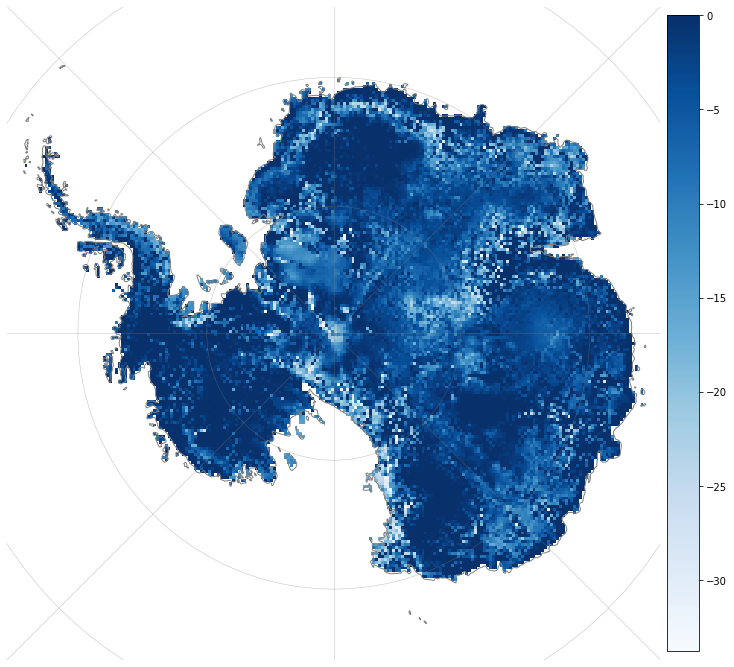

In [62]:
f_name = data_path + '/LiefferingePattyn2013/Temp_RMSE_CP_2013.mat'
try:
    basal_temp = loadmat(f_name)
    yy = basal_temp['Y'].flatten().astype('int32')*km
    xx = basal_temp['X'].flatten().astype('int32')*km
    TT = basal_temp['btemp'].flatten()
    basal_temp_map = interpolate.griddata((yy, xx), TT,
                                      (ant.ds.coords['YV'], ant.ds.coords['XV']), 
                                    method='nearest')

except:
    basal_temp_map = np.zeros(ant.nn)

ant.ds['LIEFFERINGE'] =(('Y','X'), basal_temp_map)
ant.map_grid('LIEFFERINGE', cmap='Blues', cbar=True)

/Users/tobias_stal/proj/ant_lith/ant_lithosphere


coord_factor scales the x, y values. no_data might be tricky due to float errors, but can also be removed by indexing:

In [64]:
for grid in [ant, wsb]:
    grid.ds['ADMAP2'] = (('Y', 'X'), 
                grid.read_raster(data_path + '/ADMAP2/Raster/ADMAP_2B_2017_R9_B1.tif', no_data = -1e32))

    grid.ds['ADMAP2'] = grid.ds['ADMAP2'].where(grid.ds['ADMAP2']>-10e6)

    grid.ds['BOUGER'] = (('Y', 'X'), grid.read_ascii(data_path + '/Scheinert_et_al_2016/antgg2015.txt', 
                                                crs_src = '+init=epsg:3031',
                                                x_col=0, y_col=1, data_col=8, coord_factor=km))

    grid.ds['AN_LAB'] = (('Y', 'X'), grid.read_grid(data_path + '/an/AN1-LAB/AN1-LAB.grd', xyz = ('lon','lat', 'z')  )* km) 
    
    

We use some generated polygons to select areas. If the polygons are missing, just select all:

In [65]:
for grid in [ant, wsb]:
    try:
        grid.ds['WSB'] = (('Y', 'X'), grid.assign_shape('gis/wsbs.shp', 
                                               'SELECT', map_to_int = True))
        ant.ds['EAST'] = (('Y', 'X'), ant.assign_shape('gis/east_antarctica.shp', 
                                               'SELECT', map_to_int = True))
    except:
        grid.ds['WSB'] = (('Y', 'X'), np.zeros(grid.nn))
        grid.ds['EAST'] = (('Y', 'X'), np.zeros(grid.nn))
        print('Use placeholder')



Use placeholder
Use placeholder


It is generally not advicable to save pickle objects due to security concerns, but it might be handy. Large objects must be splitted:

In [66]:
import pickle
pickle.dump(ant, open( "ant_essd.p", "wb" ))
#pickle.dump(wsb, open( "wsb_essd.p", "wb" ))

file_path = "wsb_essd.p"
n_bytes = 2**31
max_bytes = 2**31 - 1
data = bytearray(n_bytes)

print('WSB')
## write
bytes_out = pickle.dumps(wsb)
with open(file_path, 'wb') as f_out:
    for idx in range(0, len(bytes_out), max_bytes):
        print(idx)
        f_out.write(bytes_out[idx:idx+max_bytes])



WSB
0


In [67]:
file_path = "wsb_essd.p"
n_bytes = 2**31
max_bytes = 2**31 - 1
data = bytearray(n_bytes)

In [68]:
ant = pickle.load( open( "ant_essd.p", "rb" ) )
#wsb = pickle.load( open( "wsb_essd.p", "rb" ) )

file_path = "wsb_essd.p"
## read
bytes_in = bytearray(0)
input_size = os.path.getsize(file_path)
with open(file_path, 'rb') as f_in:
    for _ in range(0, input_size, max_bytes):
        bytes_in += f_in.read(max_bytes)
wsb = pickle.loads(bytes_in)


We can manibulate all datasets at once, e.g. removing offsore cover. 

In [69]:
ant.ds *= ant.ds['LAND']

Re-interpolating axes (This might take a while):

In [70]:
for data_3d in ['AN_S1', 'AN_TS', 'AN_TC', 'AN_T']:
    print(data_3d, end = ' ')
    ant.ds['%s_I'%data_3d] = ( ('Y', 'X', 'Z_NEW'), 
                           ant.change_coord(ant.ds[data_3d], ant.ds['Z'], ant.ds['Z_NEW']) )
    print('done!')

ant.ds['PMEAN_I'] = ( ('Y', 'X', 'Z_NEW'), 
                           ant.change_coord(ant.ds['PMEAN'], ant.ds['PMEAN_Z'], ant.ds['Z_NEW'], axis=-1) )
ant.ds['SMEAN_I'] = ( ('Y', 'X', 'Z_NEW'), 
                           ant.change_coord(ant.ds['SMEAN'], ant.ds['SMEAN_Z'], ant.ds['Z_NEW'], axis=-1) )

 

AN_S1 done!
AN_TS done!
AN_TC done!
AN_T done!


Investigation of published heat flow models, including uncertainty. 

In [71]:
an_uncertainty = 5*milli # 25mW/m2 estimated from LAB depth uncertainty as presented by An et al 2015
fox_uncertainty = 27*milli # 21-27mW/m2 Fox Maule et al 2005


for grid in [ant, wsb]:
    hfs = np.array([grid.ds['HF_MARTOS'].values, grid.ds['HF_FOX'].values, grid.ds['HF_AN'].values])
    
    hfs_extreme = np.array([grid.ds['HF_FOX'].values + fox_uncertainty, 
                            grid.ds['HF_FOX'].values - fox_uncertainty, 
                            grid.ds['HF_AN'].values + an_uncertainty,
                            grid.ds['HF_AN'].values - an_uncertainty,
                           grid.ds['HF_MARTOS'].values + grid.ds['HF_MARTOS_U'].values,
                           grid.ds['HF_MARTOS'].values] - grid.ds['HF_MARTOS_U'].values,)

    grid.ds['HF_MEAN'] = (('Y', 'X'), np.mean(hfs, axis=0))
    grid.ds['HF_STD'] = (('Y', 'X'), np.std(hfs , axis=0))
    grid.ds['HF_MAX'] = (('Y', 'X'), np.max(hfs_extreme , axis=0))
    grid.ds['HF_MIN'] = (('Y', 'X'), np.min(hfs_extreme , axis=0))

Asigning heat production values from Jaupard et al 2014,2016

In [72]:
A_Archean = (0.56*micro, 0.73*micro)
A_Proterozoic = (0.73*micro,0.90*micro)
A_Phanerozoic = (0.95*micro, 1.21*micro)
A_Ridges = (0.5*micro, 0.9*micro)
A_Oceanic = (0.5*micro, 0.9*micro) # Check Hasterok
A_Old_Oceanic = (0.5*micro, 0.9*micro) # Check Hasterok


scaeffer_class = dict([(1,0),
                       (2,1),
                       (3,2),
                       (4,3),
                       (5,3),
                       (6,3)])

#{'ARCHEAN': 1, 'CARBONIFEROUS': 2, 'CENOZOIC': 3, 'DEVONIAN': 4, 'LOWER JURASSIC': 5, 
# 'MESOZOIC': 6, 'No data entered': 7, 'PALEOZOIC': 8, 'PHANEROZOIC': 9, 'PROTEROZOIC': 10}
tingey_class = dict([(1,0),
                    (2,2),
                    (3,2),
                    (4,2),
                    (5,2),
                    (6,2),
                    (7, np.nan),
                    (8, 2),
                    (9, 2),
                    (10,1)])


for grid in [ant, wsb]:
    janse_grid = np.zeros(grid.nn)
    janse_grid[:] = np.nan
    for  schaeffer, janse_class in scaeffer_class.items():
        janse_grid[grid.ds['REG'] ==  schaeffer] = janse_class
    grid.ds['SCHAEFFER_CLASS'] = (('Y', 'X'), janse_grid)

    
    janse_grid = np.zeros(grid.nn)
    janse_grid[:] = np.nan
    for  tingey, janse_class in tingey_class.items():
        janse_grid[grid.ds['TINGEY'] ==  tingey] = janse_class
    grid.ds['TINGEY_CLASS'] = (('Y', 'X'), janse_grid)


    
    
A_min_map = dict([(1, A_Archean[0]), 
           (2, A_Proterozoic[0]),
           (3, A_Phanerozoic[0]),
           (4, A_Ridges[0]),
           (5, A_Oceanic[0]),
           (6, A_Old_Oceanic[0])])

   
A_max_map = dict([(1, A_Archean[1]), 
           (2, A_Proterozoic[1]),
           (3, A_Phanerozoic[1]),
           (4, A_Ridges[1]),
           (5, A_Oceanic[1]),
           (6, A_Old_Oceanic[1])])


for grid in [ant, wsb]:
    A_min = np.zeros(grid.nn)
    
    for  schaeffer_class, A in A_min_map.items():
        A_min[grid.ds['REG'] ==  schaeffer_class] = A
    grid.ds['A_MIN_SCHAEFFER'] = (('Y', 'X'), A_min)
 

    A_max = np.zeros(grid.nn)
    for  schaeffer_class, A in A_max_map.items():
        A_max[grid.ds['REG'] ==  schaeffer_class] = A
    grid.ds['A_MAX_SCHAEFFER'] = (('Y', 'X'), A_max)
    

Assign a toy 3D distribution of heat production in the crust. This assumption is, however, not valid as we don't know the vertical distribution.

In [73]:
for grid in [ant, wsb]:
    grid.ds['A'] = (('Y','X','Z'), grid.ds['A_MAX_SCHAEFFER'] * np.exp(-(grid.ds['Z']/grid.ds['AN_CRUST'])))
    
    

Plot layer cake of temperature from two models (ANTc and ANTs):

3D


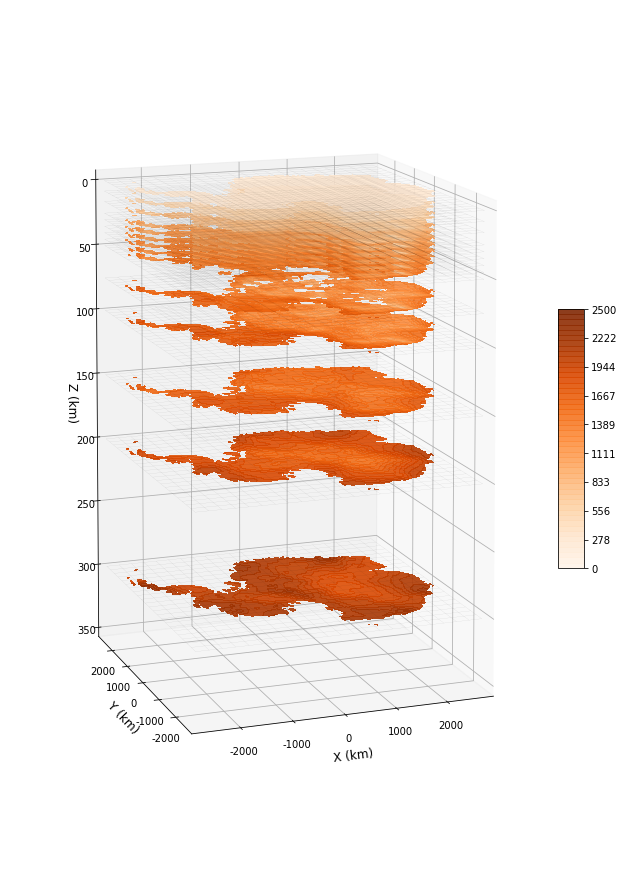

In [74]:
ant.ds['AN_T_I'] = ant.ds['AN_T'].interp(Z=ant.ds['Z_NEW'])

K = -273.15
ant.layer_cake(ant.ds['AN_T_I']-K, 
               cmap='Oranges', 
               layers = ant.ds['Z_NEW'].values,
               g_xy_sub_sample = 10, 
               g_lw = 0.15,
               figsize = (9,12),
               vmin = 0,
               elev = 9,
               vmax = 2500,
               d_alpha = 0.9,
               g_alpha = 0.2,
               d_levels = 50, 
               x_factor = km,
               y_factor = km,
               z_factor = km,
               xlabel = 'X (km)', 
               ylabel = 'Y (km)', 
               zlabel = 'Z (km)',
               save_name = 'fig/fig_1a.pdf')

Print toy heat production values:

3D


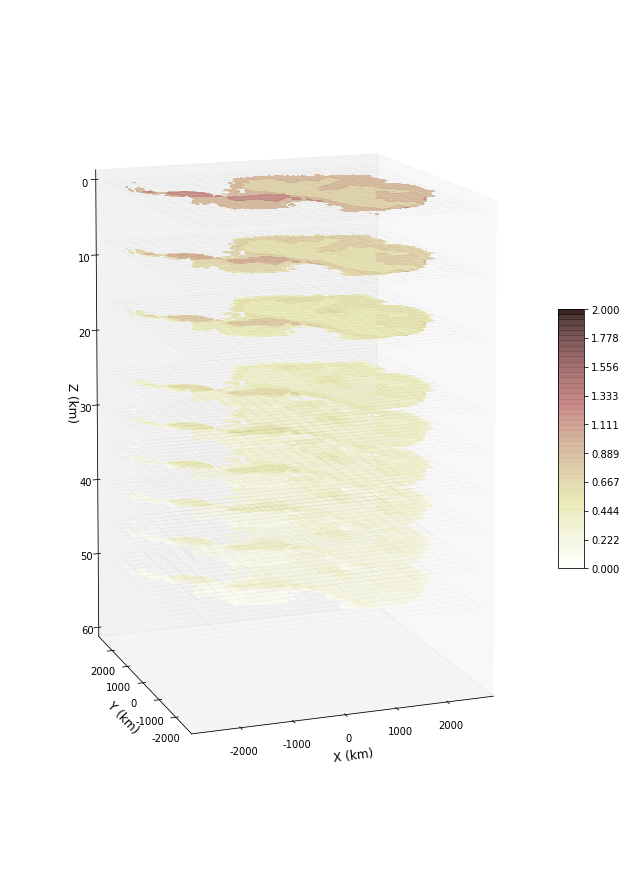

In [75]:

ant.ds['A_I'] = ant.ds['A'].interp(Z=ant.ds['Z_NEW'])

ant.layer_cake(ant.ds['A_I']*1000000, cmap='pink_r', 
               figsize = (9,12),
               layers = ant.ds['Z_NEW'].values,
               elev = 9,
               vmin = 0,
               vmax = 2,
               x_factor = km,
               y_factor = km,
               z_factor = km,
               g_xy_sub_sample = 10,
               g_lw = 0.1,
               z_lim=(60*km, 0),
               g_alpha = 0.2,
               d_levels = 50, 
               d_alpha = 0.9,
               xlabel = 'X (km)', 
               ylabel = 'Y (km)', 
               zlabel = 'Z (km)',
               save_name = 'fig/fig_1b.pdf')

In [76]:
download('http://dmc.iris.washington.edu/dms/products/emc/data/AK135F/AK135F_AVG_IDV.csv', 
        data_path + '/models/AK135F_AVG_IDV.csv')

Content:  text/csv
File ../../data/models/AK135F_AVG_IDV.csv already exists.


['../../data/models/AK135F_AVG_IDV.csv']

1D reference models can be assigned as:

In [77]:

ak_135_d, _, ak_135_vp, ak_135_vs,_,_  = np.genfromtxt( data_path + '/models/AK135F_AVG_IDV.csv', delimiter=',', unpack=True)*km #To SI unit

ant.ds.coords['AK135_Z'] = ak_135_d
ant.ds['AK135_SV'] = (('AK135_Z'), ak_135_vs)

Saved to: fig/fig_2a.pdf


/Users/tobias_stal/anaconda3/lib/python3.7/site-packages/matplotlib/axis.py:1081: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "
/Users/tobias_stal/anaconda3/lib/python3.7/site-packages/matplotlib/axis.py:1091: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "


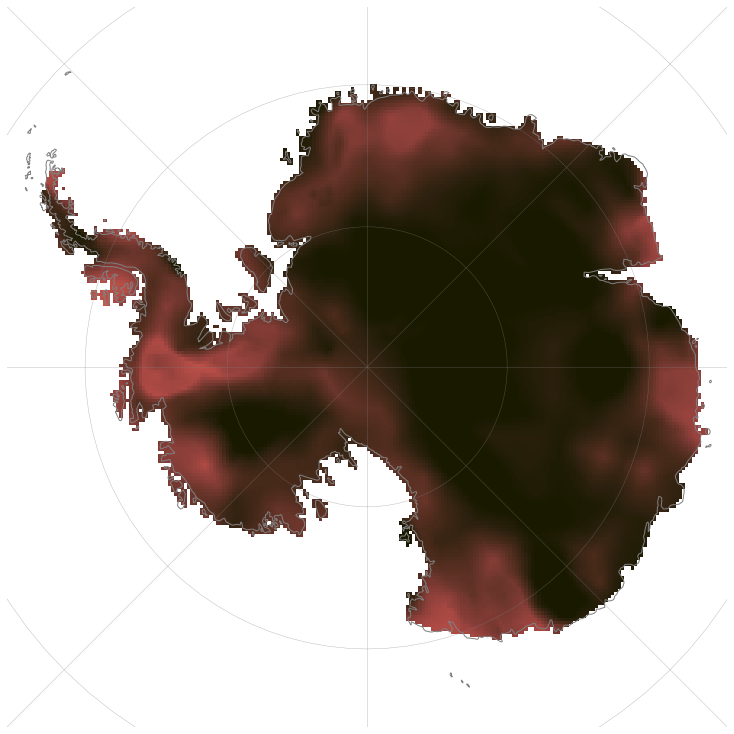

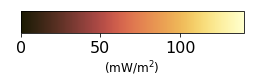

Saved to: fig/fig_2b.pdf


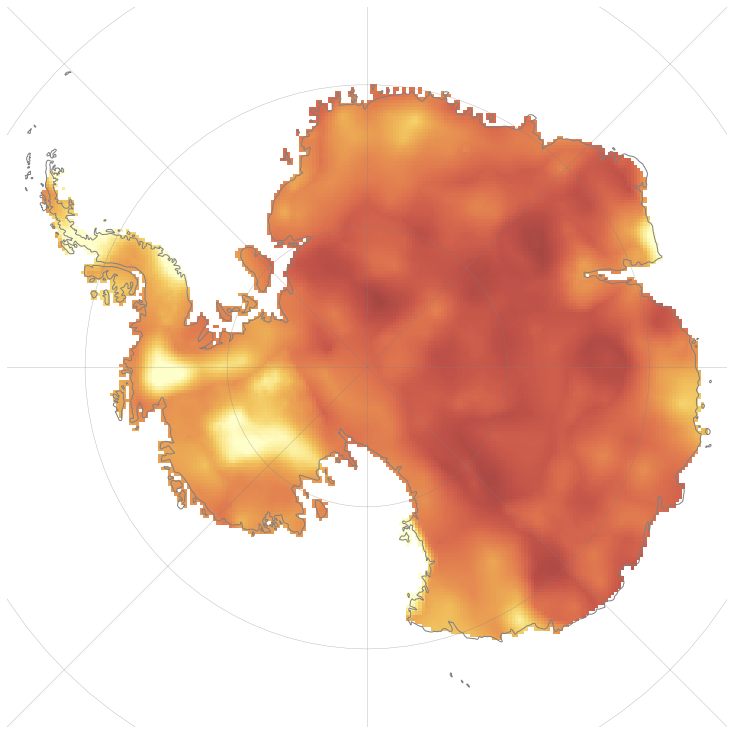

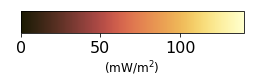

Saved to: fig/fig_2c.pdf


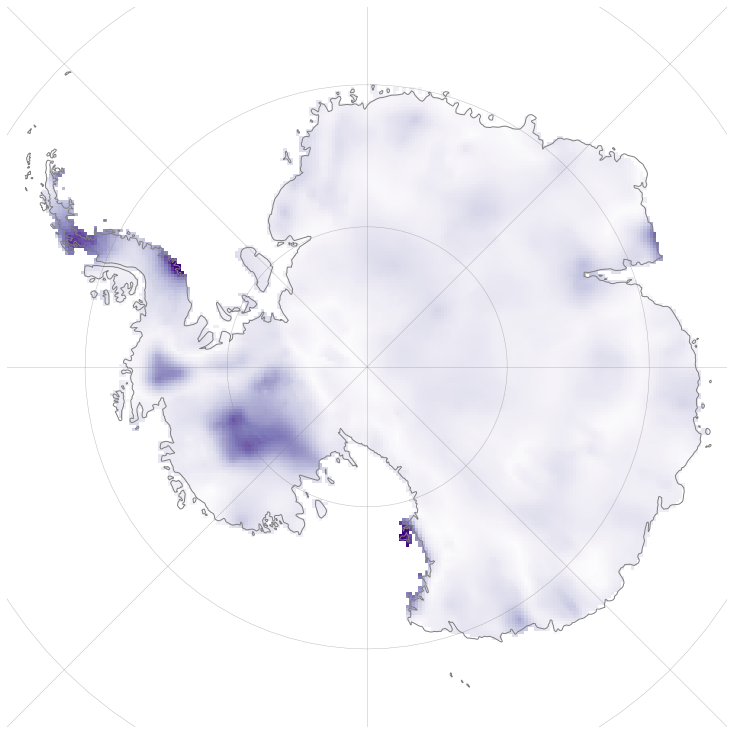

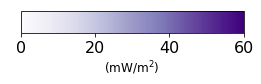

In [78]:
ant.ds *= ant.ds['LAND']
milli = 0.001

ant.map_grid(ant.ds['HF_MIN']/milli, cmap=SCM6.lajolla_r, save_name = 'fig/fig_2a.pdf', vmin = 0, vmax = 140, 
             save_cbar='fig/cbar/fig_2a.pdf', cbar_x_label= '(mW/m$^2$)', cfigsize = (4,4))
ant.map_grid(ant.ds['HF_MAX']/milli, cmap=SCM6.lajolla_r, save_name = 'fig/fig_2b.pdf', vmin = 0, vmax = 140, 
             save_cbar='fig/cbar/fig_2b.pdf', cbar_x_label= '(mW/m$^2$)', cfigsize = (4,4))
ant.map_grid(ant.ds['HF_STD']/milli, cmap='Purples', save_name = 'fig/fig_2c.pdf', vmin = 0, vmax = 60, 
             save_cbar='fig/cbar/fig_2c.pdf', cbar_x_label= '(mW/m$^2$)', cfigsize = (4,4))


Compare other datasets, e.g. CTD and Moho:

Saved to: fig/fig_s2a.pdf


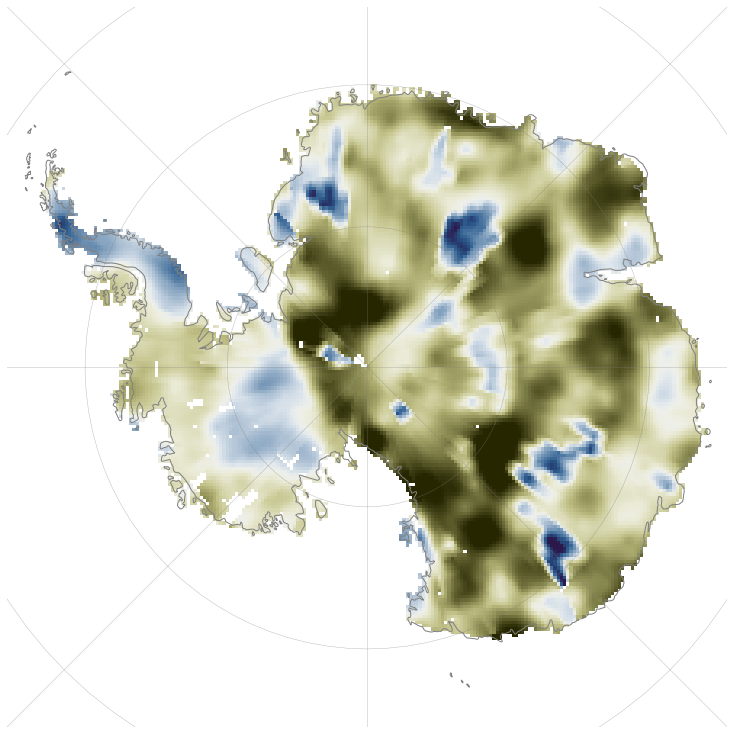

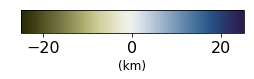

Saved to: fig/fig_s2b.pdf


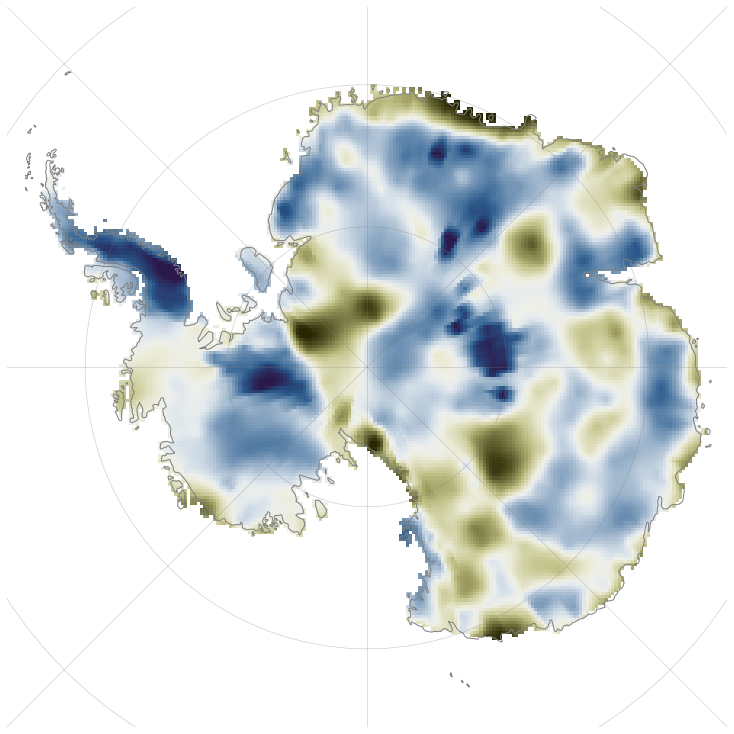

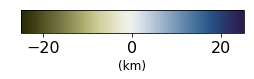

In [79]:
ant.map_grid((ant.ds['CTD_AN']-ant.ds['CTD_MARTOS'])/km, cmap=SCM6.broc_r, 
             save_name = 'fig/fig_s2a.pdf', vmin=-25, vmax=25, 
             save_cbar='fig/cbar/fig_s2a.pdf', cbar_label= '(km)', cfigsize = (4,4), cbar_x_label='(km)')

ant.map_grid((ant.ds['AN_CRUST']-ant.ds['CTD_MARTOS'])/km, cmap=SCM6.broc_r, 
             save_name = 'fig/fig_s2b.pdf', vmin=-25, vmax=25, 
             save_cbar='fig/cbar/fig_s2b.pdf', cbar_label= '(km)', cfigsize = (4,4), cbar_x_label='(km)')

Assign attribute data to ange ranges: 

In [80]:
#{'ARCHEAN': 1, 'CARBONIFEROUS': 2, 'CENOZOIC': 3, 'DEVONIAN': 4, 'LOWER JURASSIC': 5, 
# 'MESOZOIC': 6, 'No data entered': 7, 'PALEOZOIC': 8, 'PHANEROZOIC': 9, 'PROTEROZOIC': 10}
tingey_age = dict([(1,3000),
                    (2,320),
                    (3,20),
                    (4,400),
                    (5,190),
                    (6,200),
                    (7, np.nan),
                    (8, 450),
                    (9, 200),
                    (10,1500)])

age_grid = np.zeros(ant.nn)
age_grid[:] = np.nan
for  tingey, age in tingey_age.items():
    age_grid[ant.ds['TINGEY'] ==  tingey] = age
ant.ds['TINGEY_AGE'] = (('Y', 'X'), age_grid)


reg_class = dict([(1,0),
                    (2,1),
                       (3,2),
                       (4,10),
                       (5,11),
                       (6,12)])

reg_grid = np.zeros(ant.nn)
reg_grid[:] = np.nan
for  reg, reg_col in reg_class.items():
    reg_grid[ant.ds['REG'] ==  reg] = reg_col
ant.ds['REG_COL'] = (('Y', 'X'), reg_grid)


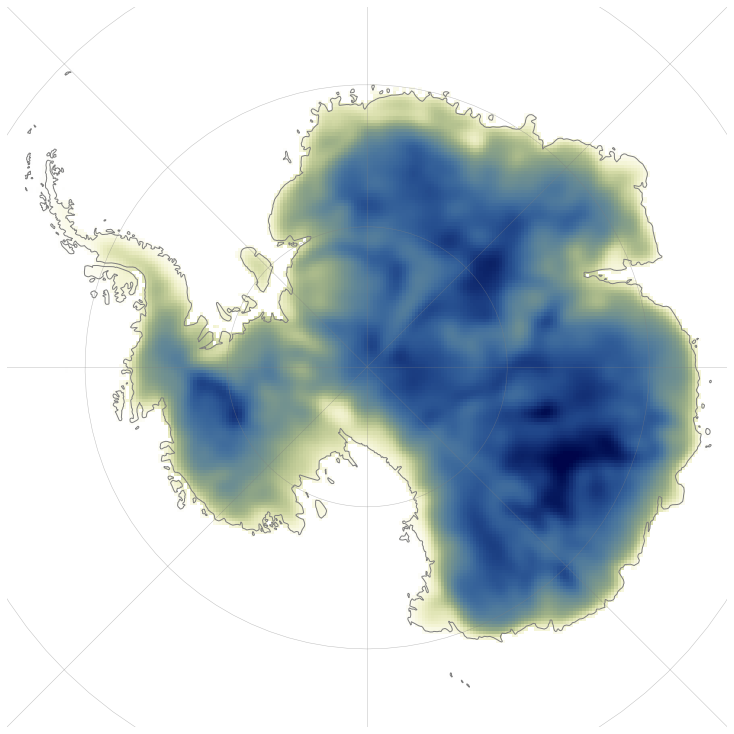

Saved to: fig/fig_2d.pdf


/Users/tobias_stal/anaconda3/lib/python3.7/site-packages/matplotlib/axis.py:1081: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "
/Users/tobias_stal/anaconda3/lib/python3.7/site-packages/matplotlib/axis.py:1091: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "


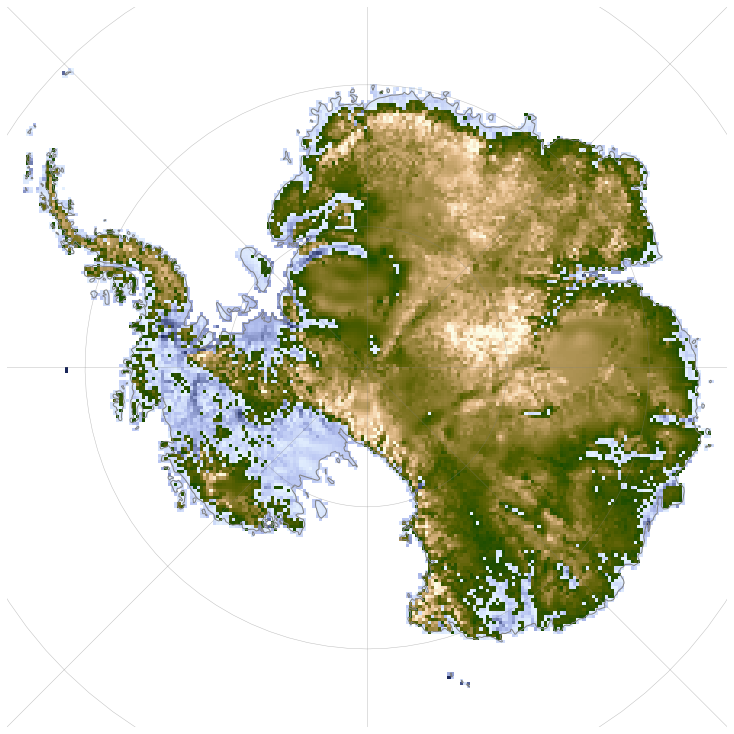

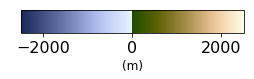

In [81]:

ice_ro = 916.7

ice_ro = 916.7
sea_ro = 1025

# LP filter of ice thickness
crust_smooth = 60*km

for grid in [ant, wsb]:  
    lith_ro = (grid.ds['AN_CRUST']*km*grid.ds['AFONSO_CRUST_RHO'] + 
               (grid.ds['AN_LAB']*km-grid.ds['AN_CRUST']*km)*grid.ds['AFONSO_LITH_RHO'])/grid.ds['AN_LAB']/km
    density_factor = ice_ro / lith_ro
    
    boyancy = grid.ds['ICE'] * density_factor
    boyancy_smooth = gaussian_filter(np.nan_to_num(boyancy), 
                                     sigma=int(crust_smooth/grid.res[0]), 
                                     mode ='nearest')
      
    grid.ds['BED_I'] = grid.ds['BED'] + boyancy_smooth
    
    grid.ds['BEDMAP_I_LIFT'] = (('Y', 'X'), boyancy_smooth)

    grid.ds['BED_I_T'] = grid.ds['BED'] + boyancy_smooth
    
    # We also apply one iteration with ocean water loading. Further refienments are not meaningful, given the 
    # uncertainties in the datasets. 
    water_load = grid.ds['BED_I'].where(grid.ds['BED_I']<0)*grid.ds['LAND'] * sea_ro / lith_ro
    water_load = np.nan_to_num(water_load, nan=0)
    grid.ds['WATER_LOAD_I'] = (('Y', 'X'), water_load)
    grid.ds['BEDMAP_I'] = grid.ds['BED_I']+grid.ds['WATER_LOAD_I']
    
    

ant.ds *= ant.ds['LAND']
    
ant.map_grid('BEDMAP_I_LIFT', cmap=SCM6.davos_r)   
    
    
ant.map_grid('BEDMAP_I', 
             save_name = 'fig/fig_2d.pdf', 
             vmin = -2500, vmax=2500, cmap=SCM6.oleron, save_cbar='fig/cbar/fig_2d.pdf', 
             cfigsize = (4,4), cbar_x_label='(m)')


Save the adjusted topography to raster.

In [82]:
ant.grid_to_raster('BEDMAP_I', 'bedmap2_gia.tif')

Show regional model data:

Saved to: fig/fig_4d.pdf


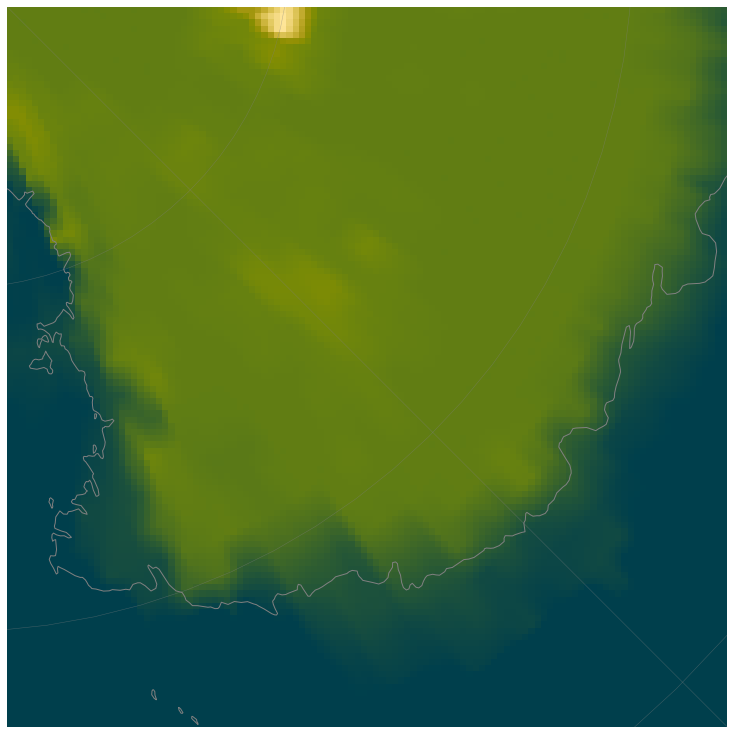

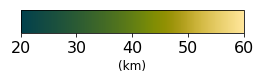

In [83]:

wsb.map_grid(wsb.ds['AN_CRUST']/km, 
             save_name = 'fig/fig_4d.pdf', 
             vmin = 20, vmax=60, cmap=SCM6.bamako, save_cbar='fig/cbar/fig_4d.pdf', 
             cfigsize = (4,4), cbar_x_label='(km)')



Make ternary maps for e.g. segmentation:

Saved to: fig/fig_s4a.pdf


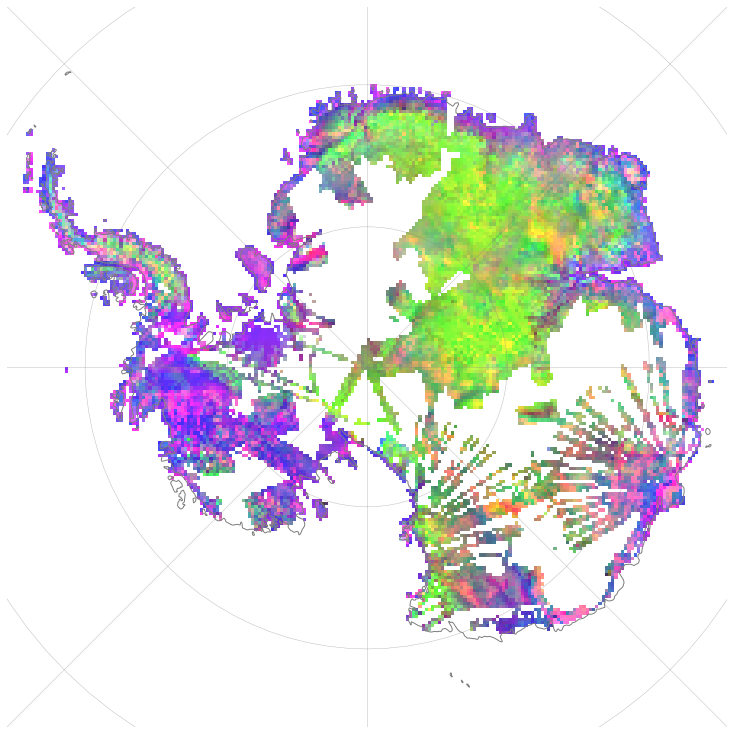

Saved to: fig/fig_s4b.pdf


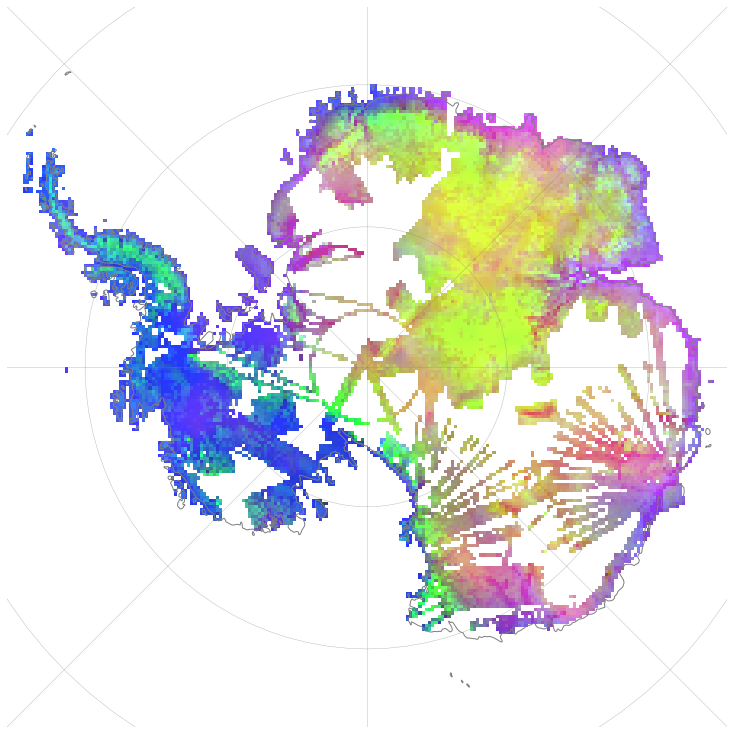

Saved to: fig/fig_s4c.pdf


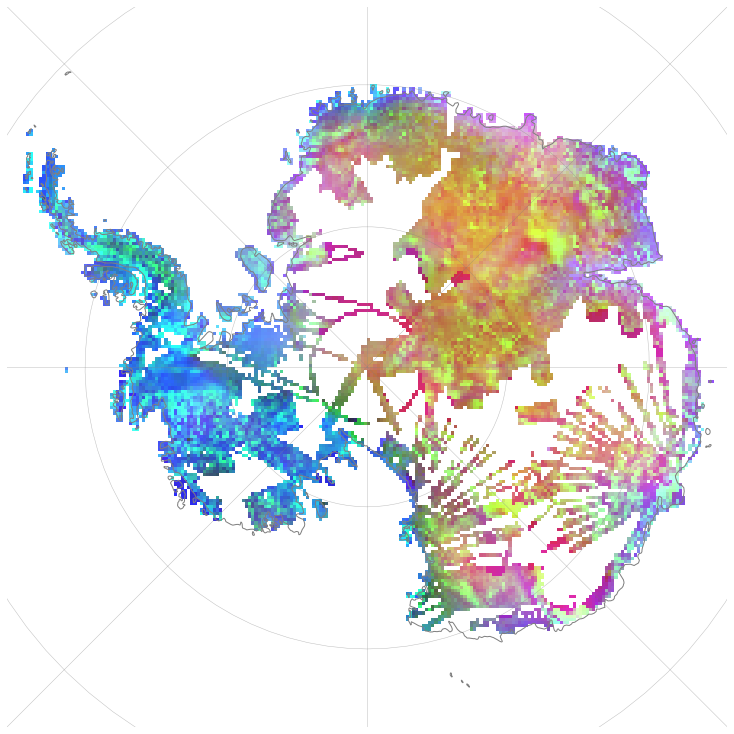

In [84]:
def standard(a, p = 5):
    a *=ant.ds['LAND']
    a = (a - np.nanmean(a)) / np.nanstd(a)
    l = np.nanpercentile(a, p)
    h = np.nanpercentile(a, 100-p)
    a = np.clip(a, l, h)
    return a

def normalise(a):
    return (a - np.nanmin(a))/(np.nanmax(a)-np.nanmin(a))


grav_mask = np.isfinite(ant.ds['BOUGER'])
mag_mask = np.isfinite(ant.ds['ADMAP2'])
elev_mask = np.isfinite(ant.ds['BEDMAP_I'])

mask = grav_mask * mag_mask * elev_mask * ant.ds['LAND']

s_grav = standard(ant.ds['BOUGER'].values)
s_mag = standard(ant.ds['ADMAP2'].values)
s_elev = standard(ant.ds['BEDMAP_I'].values)
s_seis_100 = standard(ant.ds['AN_S1'].sel(Z=100*km).values)

ant.ds['MEG'] = (('Y', 'X', 'RGBA'), np.dstack((s_mag, s_elev, s_grav, mask)))
ant.ds['MEG'] = normalise(ant.ds['MEG'])
ant.ds['MEG'] = ant.ds['MEG'] * mask 

ant.map_grid('MEG',save_name = 'fig/fig_s4a.pdf')

mask = grav_mask * elev_mask * ant.ds['LAND']
s_seis_100 = standard(ant.ds['AN_S1'].sel(Z=100*km).values)
s_grav = standard(ant.ds['BOUGER'].values)
s_elev = standard(ant.ds['BEDMAP_I'].values)

ant.ds['SEG'] = (('Y', 'X', 'RGBA'), np.dstack((s_seis_100, s_elev, s_grav, mask)))
ant.ds['SEG'] = normalise(ant.ds['SEG'])
ant.ds['SEG'] = ant.ds['SEG'] * mask 
ant.map_grid('SEG', save_name = 'fig/fig_s4b.pdf')

ant.ds['SMG'] = (('Y', 'X', 'RGBA'), np.dstack((s_seis_100, s_mag, s_grav, mask)))
ant.ds['SMG'] = normalise(ant.ds['SMG'])
ant.ds['SMG'] = ant.ds['SMG'] * mask 
ant.map_grid('SMG', save_name = 'fig/fig_s4c.pdf')



In [85]:
ant.grid_to_raster('SMG', save_name= 'smg.tif')
ant.grid_to_raster('SEG', save_name= 'seg.tif')
ant.grid_to_raster('MEG', save_name= 'meg.tif')

Also save color channels. 

Saved to: fig/fig_s3a_R.pdf


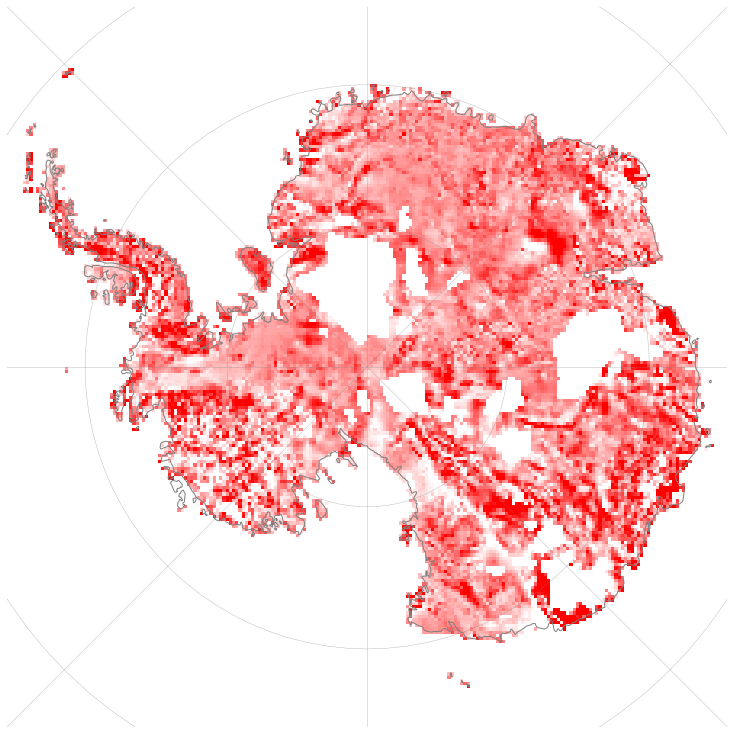

Saved to: fig/fig_s3a_G.pdf


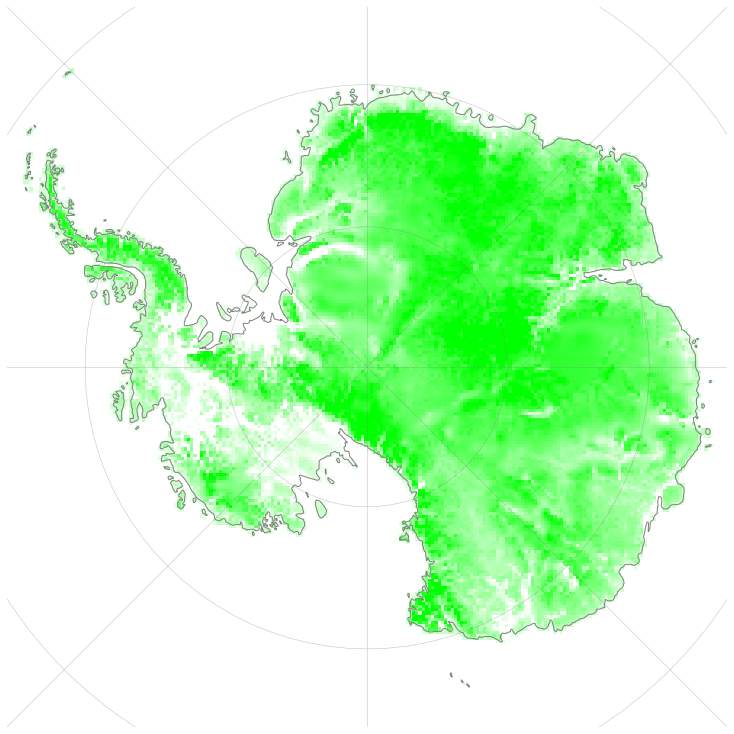

Saved to: fig/fig_s3a_B.pdf


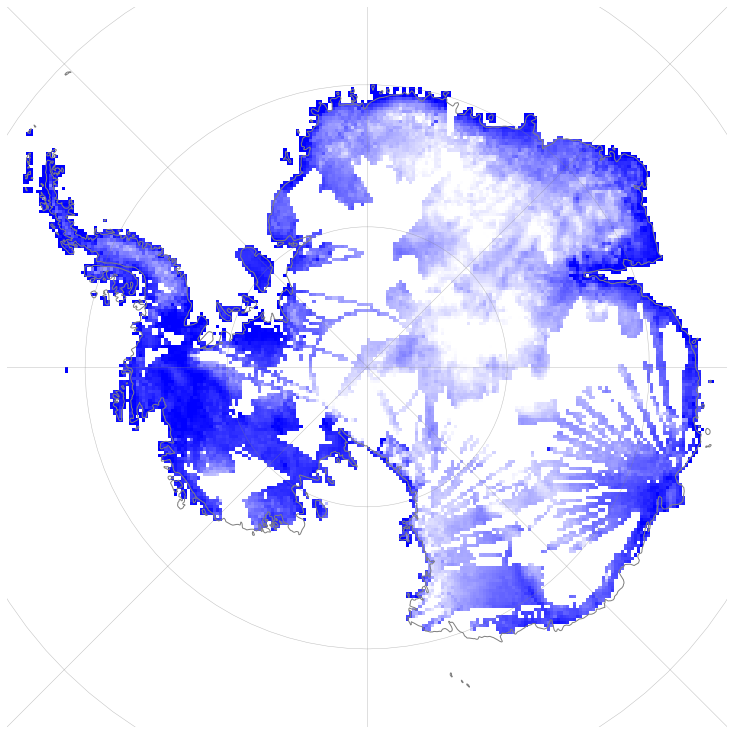

Saved to: fig/fig_s3b_R.pdf


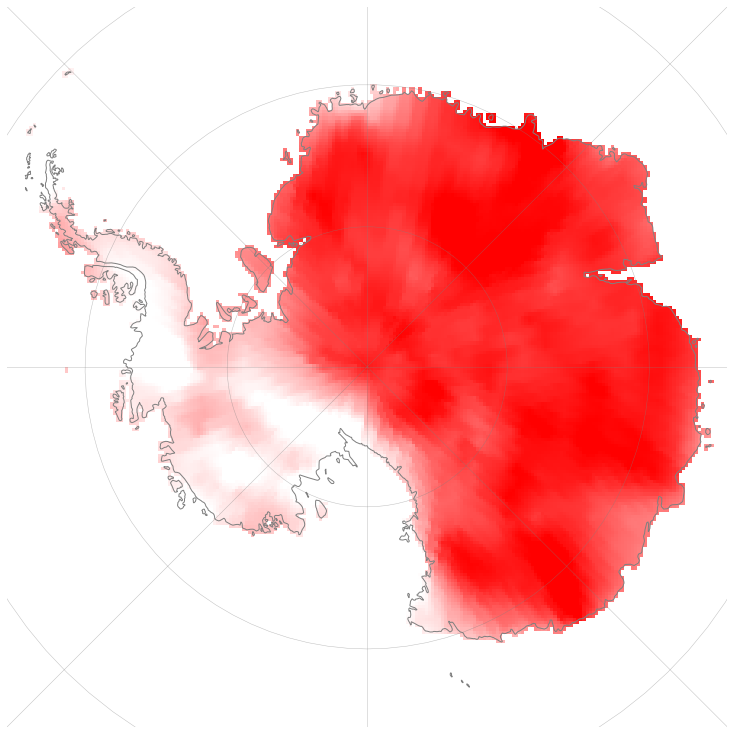

Saved to: fig/fig_s3b_G.pdf


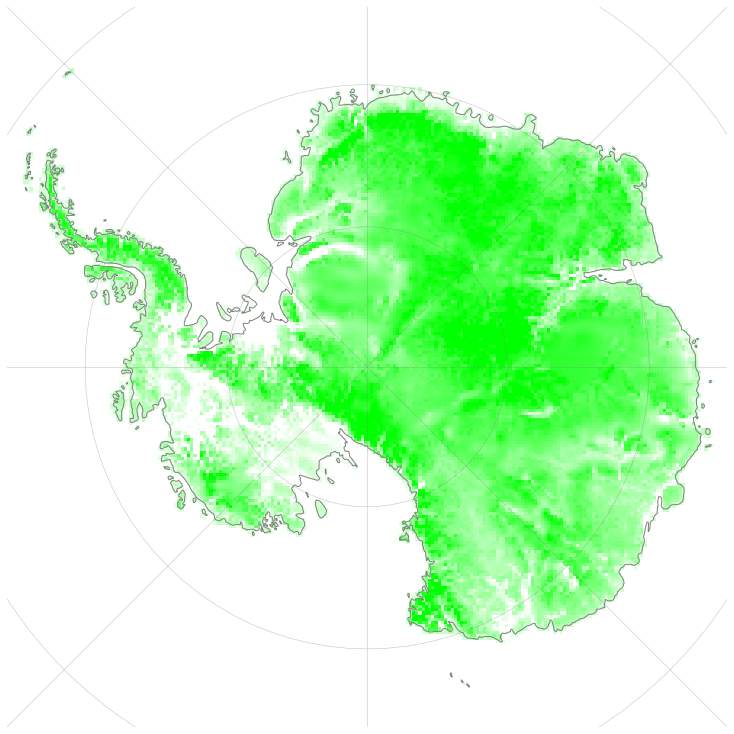

Saved to: fig/fig_s3b_B.pdf


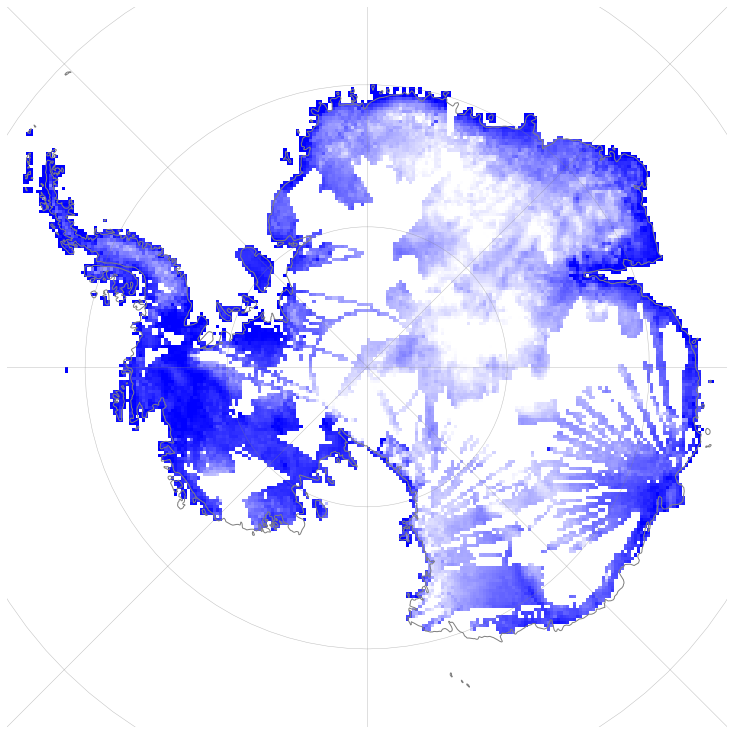

Saved to: fig/fig_s3c_R.pdf


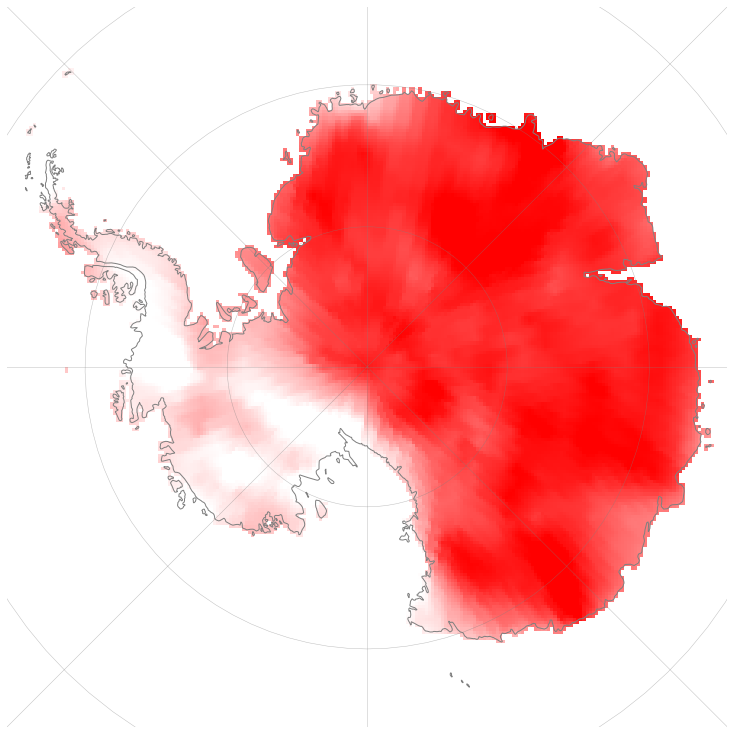

Saved to: fig/fig_s3c_G.pdf


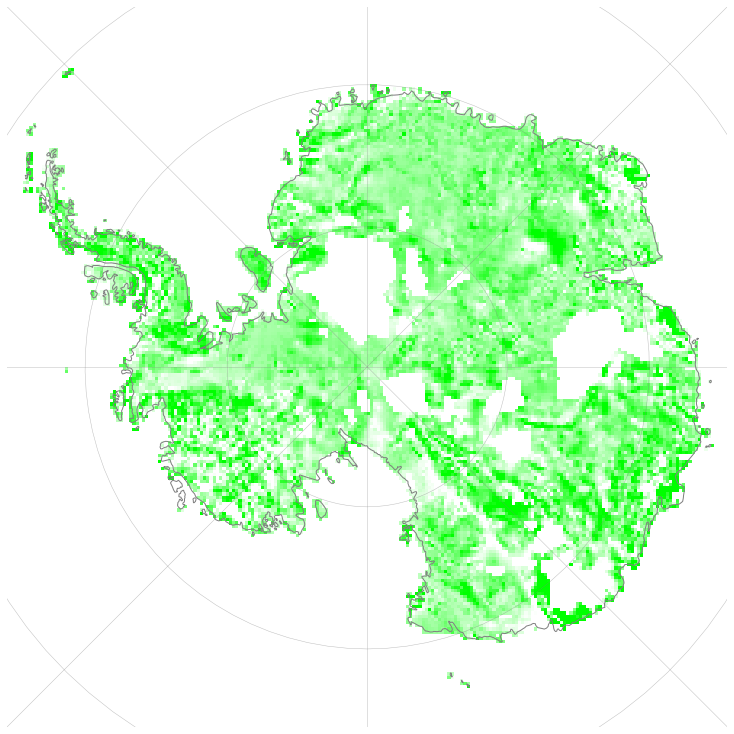

Saved to: fig/fig_s3c_B.pdf


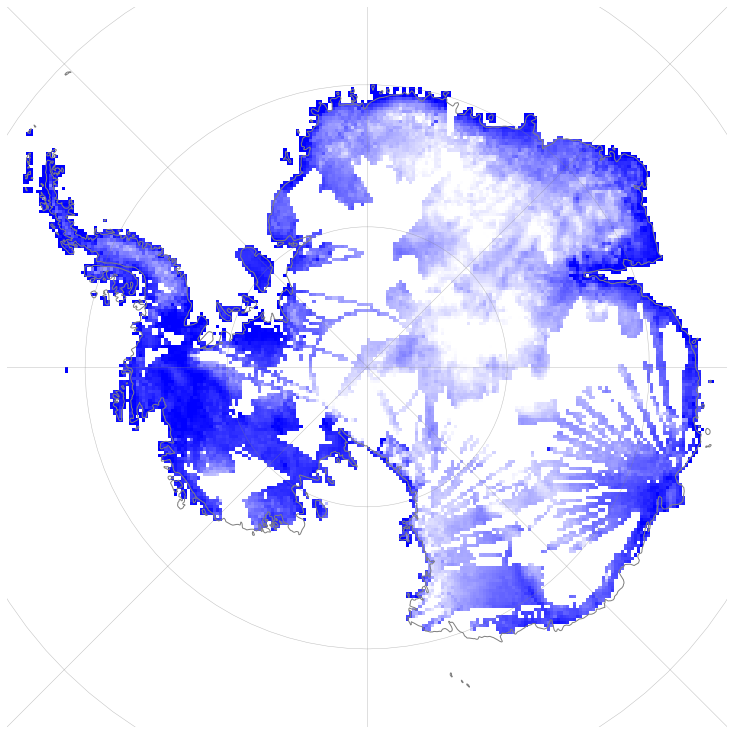

In [86]:
ones = np.ones(ant.nn)

ant.map_grid(np.dstack((ones, 1-normalise(s_mag), 1-normalise(s_mag), mag_mask)), save_name = 'fig/fig_s3a_R.pdf')
ant.map_grid(np.dstack((1-normalise(s_elev), ones, 1-normalise(s_elev), ant.ds['LAND'])), save_name = 'fig/fig_s3a_G.pdf')
ant.map_grid(np.dstack((1-normalise(s_grav), 1-normalise(s_grav), ones, grav_mask)), save_name = 'fig/fig_s3a_B.pdf')

ant.map_grid(np.dstack((ones, 1-normalise(s_seis_100), 1-normalise(s_seis_100), ant.ds['LAND'])), save_name = 'fig/fig_s3b_R.pdf')
ant.map_grid(np.dstack((1-normalise(s_elev), ones, 1-normalise(s_elev), ant.ds['LAND'])), save_name = 'fig/fig_s3b_G.pdf')
ant.map_grid(np.dstack((1-normalise(s_grav), 1-normalise(s_grav), ones, grav_mask)), save_name = 'fig/fig_s3b_B.pdf')

ant.map_grid(np.dstack((ones, 1-normalise(s_seis_100), 1-normalise(s_seis_100), ant.ds['LAND'])), save_name = 'fig/fig_s3c_R.pdf')
ant.map_grid(np.dstack((1-normalise(s_mag), ones, 1-normalise(s_mag), mag_mask)), save_name = 'fig/fig_s3c_G.pdf')
ant.map_grid(np.dstack((1-normalise(s_grav), 1-normalise(s_grav), ones, grav_mask)), save_name = 'fig/fig_s3c_B.pdf')

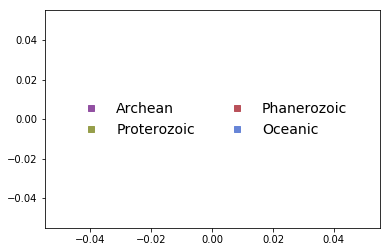

In [87]:
# Save legends for three color plots separately

#https://medialab.github.io/iwanthue/
geo_colors = ["#9250a2",
"#969e4a",
"#b9515a",              
"#6785d7",]
geo_cmap = mcolors.ListedColormap(geo_colors)


def export_legend(labels, filename="legend.png", expand=[-5,-5,5,5], colors = ["red", "green", "blue"], ncol=3):
    f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
    handles = [f("s", colors[i]) for i in range(len(labels))]
    legend = plt.legend(handles, labels, ncol=ncol, frameon=False, loc=10,prop={'size':14})
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, transparent=True, dpi=600, bbox_inches=bbox, pad_inches=0)

export_legend(['Mag','Topo','Grav'], filename = 'fig/cbar/fig_s4a.pdf')
export_legend(['sv 100km','Topo','Grav'], filename = 'fig/cbar/fig_s4b.pdf')
export_legend(['sv 100km','Mag', 'Grav'], filename = 'fig/cbar/fig_s4c.pdf')


geo_ages = ['Archean','Proterozoic','Phanerozoic', 'Oceanic']

export_legend(geo_ages, 
              filename = 'fig/cbar/fig_4c.pdf', colors = geo_colors, ncol=2)

export_legend(geo_ages, 
              filename = 'fig/cbar/fig_4c.pdf', colors = geo_colors, ncol=2)

Import geological database:

In [88]:
samples_all = pd.read_csv(data_path + '/rock_database/sample.csv', 
                         encoding = 'ISO-8859-1',
                         low_memory=False)

age_df = pd.read_csv(data_path + '/rock_database/age.csv')


samples_df = samples_all.loc[samples_all['latitude'] <= -60] # Remove all north of -60
samples_all = None # Free memory

In [89]:
samples_df = samples_df.merge(age_df, left_on='age_id', right_on='age_id')

# For now, we can drop some columns 
drop_columns = ['loc_prec', 'qgis_geom', 'datum', 'sample_id', 
                'age_id', 'material', 'country_id', 'trace_id', 
                'method_id', 'major_id', 'comp_id', 'rgroup_id', 
               'comments', 'protolith', 'ref_id', 'iso_id', 
               'sia_scheme', 'qap_name', 'frost_class1', 'frost_class2',
               'frost_class3', 'quartz', 'feldspar', 'lithics', 'texture',
               'facies', 'sample_name', 'sample_description', 'depth']
samples_df = samples_df.drop(drop_columns, axis=1)

# We are also only interested in records that contains some info that we can use for heat estimates
needed_data = ['heat_production', 'age_min', 'age', 'age_max', 'age_sd', 'time_period_min',
       'time_period', 'time_period_max']
samples_df = samples_df.dropna(subset=needed_data, how='all')

Unpublished code to convert geological age to years:

In [90]:
try:
    from agrid.strat import Strat

    download('https://raw.githubusercontent.com/TobbeTripitaka/strat2file/master/ChronostratChart2018-08.xlsx', 
             'ChronostratChart2018-08.xlsx')
    S = Strat()
except:
    print('Strat not availible.')

27.0KB [00:00, 1.82kKB/s]                  

Content:  application/octet-stream
reading:  ./ChronostratChart2018-08.xlsx


In [91]:
S.verbose = False
choice_1 = samples_df['age']
choice_2 = samples_df[['age_min', 'age_max']].mean(axis=1)
try:
    choice_3 = samples_df['time_period'].apply(lambda x: S.geo_to_year(str(x), period = False) )
except:
    choice_3 = choice_2
    print('Can not reproduce all ages. Strat package missing.')

choice_3[choice_3 == 4600.0] = np.nan

#choce_4a = samples_df['time_period_max'].apply(lambda x: S.geo_to_year(x, period = True)[1] ) 
#choce_4b = samples_df['time_period_min'].apply(lambda x: S.geo_to_year(x, period = True)[0] )
#choice_4 = pd.concat((choce_4a, choce_4b), axis=1).mean(axis=1)
#for choice in [choice_2, choice_3, choice_4]:


print(choice_1.max())
print(choice_2.max())
print(choice_3.max())


samples_df['AGE'] = choice_1
for choice in [choice_2,choice_3]:
    samples_df['AGE'] = samples_df['AGE'].fillna(choice)

No definition for expression.
No definition for expression.
No definition for expression.
No definition for expression.
No definition for expression.
No definition for expression.
No definition for expression.
No definition for expression.
No definition for expression.
No definition for expression.
No definition for expression.
No definition for expression.
No definition for expression.
No definition for expression.
No definition for expression.
No definition for expression.
No definition for expression.
No definition for expression.
No definition for expression.
No definition for expression.
No definition for expression.
No definition for expression.
No definition for expression.
No definition for expression.
No definition for expression.
No definition for expression.
3520.0
3850.0
3400.0


Asign heat production value from crustal age. 

In [92]:
criteria = [samples_df['AGE'].between(2500, 4000), 
            samples_df['AGE'].between(542, 2500), 
            samples_df['AGE'].between(0, 542)]
values = [np.mean((0.56, 0.73)), np.mean((0.73, 0.90)), np.mean((0.95,1.21))]

samples_df['A_AGE'] = np.select(criteria, values, 0)


criteria = [samples_df['AGE'].between(2500, 4000), 
            samples_df['AGE'].between(542, 2500), 
            samples_df['AGE'].between(0, 542)]
values = [np.mean((0.56*micro, 0.73*micro)), 
          np.mean((0.73*micro, 0.90*micro)), 
          np.mean((0.95*micro,1.21*micro))]

samples_df['GARD_AGE'] = np.select(criteria, values, 0)

Generate mapped statistics from the database

In [93]:
#function : a user-defined function which takes a 1D array of values, 
#and outputs a single numerical statistic. This function will be called on the values in each bin. 
#Empty bins will be represented by function([]), or NaN if this returns an error.

def mode(x):
    values, counts = np.unique(x, return_counts=True)
    m = counts.argmax()
    return values[m]

xi, yi = proj.transform(proj.Proj('+init=epsg:4326'),
                                proj.Proj('+init=epsg:3031'), 
                        samples_df['longitude'].values, samples_df['latitude'].values)


ant.ds['GARD_AGE_MEAN'] = (('Y', 'X'), stats.binned_statistic_2d(yi, xi, 
                                samples_df['AGE'], 
                                statistic='mean', 
                                bins=ant.nn, 
                                range= [[ant.left, ant.right], [ant.down, ant.up]], 
                                expand_binnumbers=False)[0])

ant.ds['GARD_AGE_MEAN'] *= ant.ds['LAND']

ant.ds['GARD_AGE_COUNT'] = (('Y', 'X'), stats.binned_statistic_2d(yi, xi, 
                                samples_df['AGE'], 
                                statistic='count', 
                                bins=ant.nn, 
                                range= [[ant.left, ant.right], [ant.down, ant.up]], 
                                expand_binnumbers=False)[0] )
ant.ds['GARD_AGE_COUNT']*= ant.ds['LAND']

ant.ds['GARD_AGE_SD'] = (('Y', 'X'), stats.binned_statistic_2d(yi, xi, 
                                samples_df['AGE'], 
                                statistic=np.std, 
                                bins=ant.nn, 
                                range= [[ant.left, ant.right], [ant.down, ant.up]], 
                                expand_binnumbers=False)[0] )

ant.ds['GARD_AGE_SD']*= ant.ds['LAND']



ant.ds['GARD_AGE_MODE'] = (('Y', 'X'), stats.binned_statistic_2d(yi, xi, 
                                samples_df['A_AGE'], 
                                statistic=mode, 
                                bins=ant.nn, 
                                range= [[ant.left, ant.right], [ant.down, ant.up]], 
                                expand_binnumbers=False)[0] )

ant.ds['GARD_AGE_MODE']*= ant.ds['LAND']


More test maps. E.g. nearest geochronological age:

MIN <xarray.DataArray 'NEAREST_GEO' ()>
array(0.012) MAX <xarray.DataArray 'NEAREST_GEO' ()>
array(3395.)


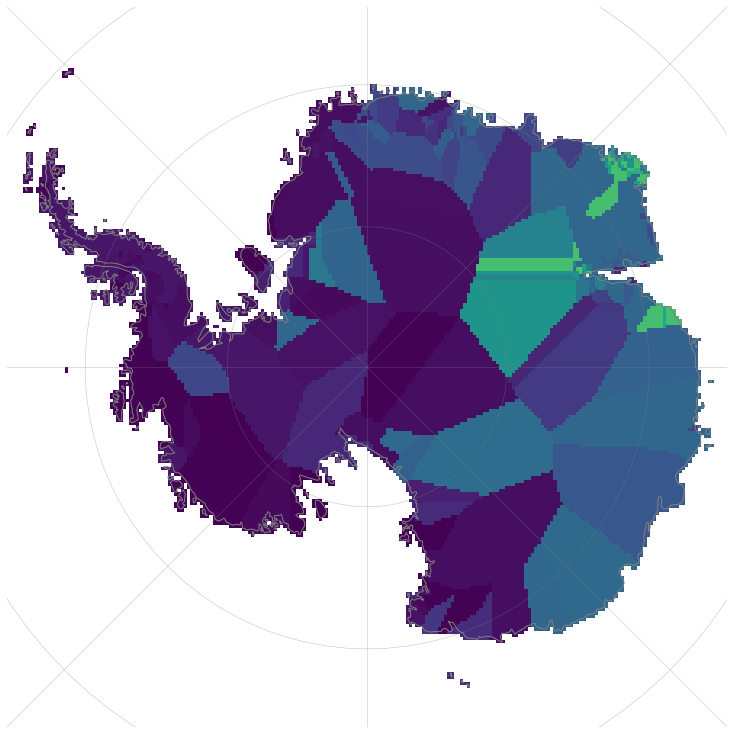

In [94]:
A_mean = stats.binned_statistic_2d(yi, xi, 
                                samples_df['AGE'], 
                                statistic='mean', 
                                bins=ant.nn, 
                                range= [[ant.left, ant.right], [ant.down, ant.up]], 
                                expand_binnumbers=False)


# Remove samples claimed to be from bins that are not outcrops
geo_bins = np.logical_and(np.isfinite(A_mean[0]),ant.ds['OUTCROP'].values)


x_pos = ant.ds['XV'].values[geo_bins]
y_pos = ant.ds['YV'].values[geo_bins]
val = A_mean[0][geo_bins]

ant.ds['NEAREST_GEO'] = (('Y', 'X') ,interpolate.griddata((y_pos, x_pos),val,(ant.ds.coords['YV'], 
                                    ant.ds.coords['XV']), 
                                    method='nearest'))

ant.ds['NEAREST_GEO'] *= ant.ds['LAND'] 


print('MIN', ant.ds['NEAREST_GEO'].min(), 'MAX', ant.ds['NEAREST_GEO'].max())


test_age = ant.ds['NEAREST_GEO']# 
#test_age = 4600 * np.ones(ant.nn)

#cmap_strat
ant.map_grid(test_age, cmap=cmap_strat, cbar=False, norm=norm_strat, vmin =0, vmax=4600,
             cfigsize = (4,4), cbar_x_label='(Ma)')

Combine datastes to generate heat production map:

In [95]:
xi, yi = proj.transform(proj.Proj('+init=epsg:4326'),
                                proj.Proj('+init=epsg:3031'), 
                        samples_df['longitude'].values, samples_df['latitude'].values)


micro = 0.000001
A_Archean = (0.56*micro, 0.73*micro)
A_Proterozoic = (0.73*micro,0.90*micro)
A_Phanerozoic = (0.95*micro, 1.21*micro)
A_Ridges = (0.95*micro, 1.21*micro)
A_Oceanic = (0.1*micro, 0.2*micro) # Check Hasterok
A_Old_Oceanic = (0.1*micro, 0.2*micro) # Check Hasterok


scaeffer_class = dict([(1,0),
                       (2,1),
                       (3,2),
                       (4,3),
                       (5,3),
                       (6,3)])

#{'ARCHEAN': 1, 'CARBONIFEROUS': 2, 'CENOZOIC': 3, 'DEVONIAN': 4, 'LOWER JURASSIC': 5, 
# 'MESOZOIC': 6, 'No data entered': 7, 'PALEOZOIC': 8, 'PHANEROZOIC': 9, 'PROTEROZOIC': 10}
tingey_class = dict([(1,0),
                    (2,2),
                    (3,2),
                    (4,2),
                    (5,2),
                    (6,2),
                    (7, np.nan),
                    (8, 2),
                    (9, 2),
                    (10,1)])


for grid in [ant, wsb]:
    janse_grid = np.zeros(grid.nn)
    janse_grid[:] = np.nan
    for  schaeffer, janse_class in scaeffer_class.items():
        janse_grid[grid.ds['REG'] ==  schaeffer] = janse_class
    grid.ds['SCHAEFFER_CLASS'] = (('Y', 'X'), janse_grid)

    
    janse_grid = np.zeros(grid.nn)
    janse_grid[:] = np.nan
    for  tingey, janse_class in tingey_class.items():
        janse_grid[grid.ds['TINGEY'] ==  tingey] = janse_class
    grid.ds['TINGEY_CLASS'] = (('Y', 'X'), janse_grid)
    
    
    grid.ds['GARD_AGE_MODE'] = (('Y', 'X'), stats.binned_statistic_2d(yi, xi, 
                                samples_df['AGE'], 
                                statistic=mode, 
                                bins=grid.nn, 
                                range= [[grid.down, grid.up],[grid.left, grid.right]], 
                                expand_binnumbers=False)[0] )
    
    
    gard_mode = np.copy(grid.ds['GARD_AGE_MODE'])
    mask = np.isnan(gard_mode)
    
    bins = np.array([5000, 2500, 542, 0])
    inds = np.digitize(gard_mode, bins).astype(float)-1
    inds[mask] = np.nan

    grid.ds['GARD_CLASS'] = (('Y', 'X'), inds)
    grid.ds['GARD_CLASS'] *= grid.ds['OUTCROP']
    
    # Merge
    geo_class = grid.ds['GARD_CLASS'].copy()
    
    
    geo_class = geo_class.fillna(grid.ds['TINGEY_CLASS']) 
    geo_class = geo_class.fillna(grid.ds['SCHAEFFER_CLASS']) 
    grid.ds['GEO_CLASS'] = (('Y', 'X'), geo_class)


In [96]:

ant.ds['GARD_AGE_MEAN'] = (('Y', 'X'), stats.binned_statistic_2d(yi, xi, 
                                samples_df['AGE'], 
                                statistic='mean', 
                                bins=ant.nn, 
                                range= [[ant.left, ant.right], [ant.down, ant.up]], 
                                expand_binnumbers=False)[0])

ant.ds['GARD_AGE_MEAN'] *= ant.ds['LAND']

Generate regional maps:

Saved to: fig/fig_4a.pdf


/Users/tobias_stal/anaconda3/lib/python3.7/site-packages/matplotlib/axis.py:1081: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "
/Users/tobias_stal/anaconda3/lib/python3.7/site-packages/matplotlib/axis.py:1091: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "


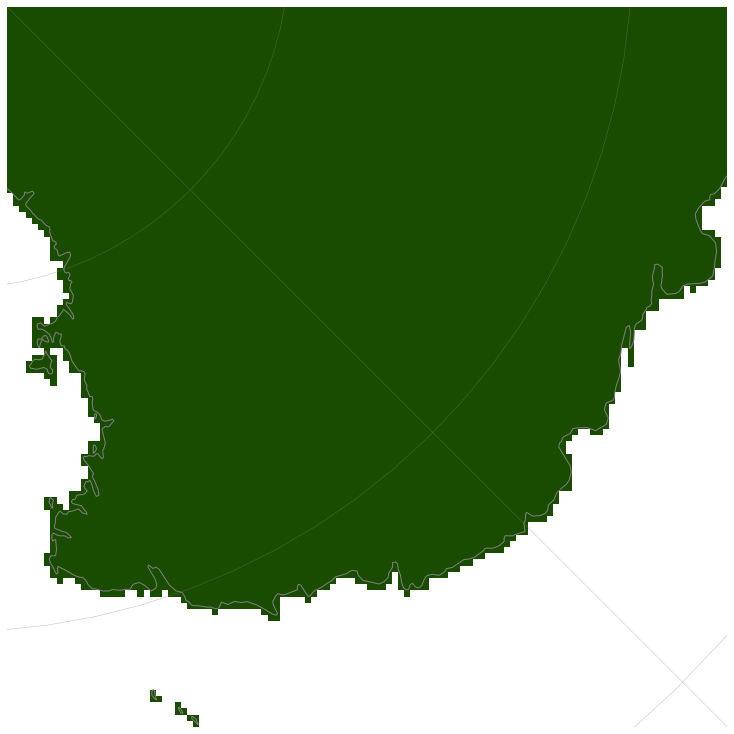

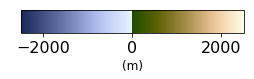

Saved to: fig/fig_4b.pdf


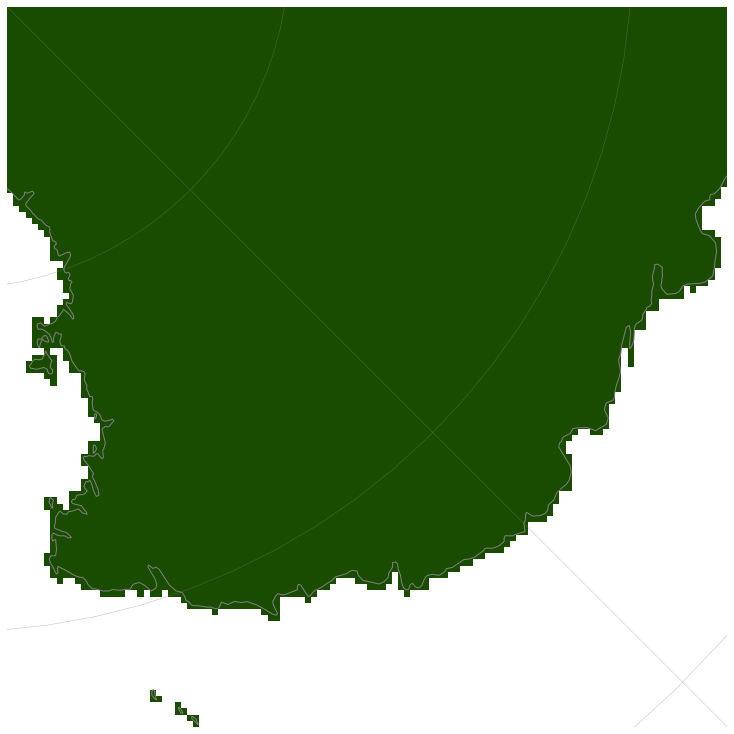

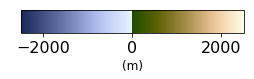

In [97]:
wsb.map_grid(wsb.ds['BED']*wsb.ds['WSB']*wsb.ds['LAND'], 
             save_name = 'fig/fig_4a.pdf', 
             vmin = -2500, vmax=2500, cmap=SCM6.oleron, 
             save_cbar='fig/cbar/fig_4a.pdf',cfigsize = (4,4), cbar_x_label='(m)')

wsb.map_grid(wsb.ds['BEDMAP_I']*wsb.ds['WSB']*wsb.ds['LAND'], 
             save_name = 'fig/fig_4b.pdf', 
             vmin = -2500, vmax=2500, cmap=SCM6.oleron, 
             save_cbar='fig/cbar/fig_4b.pdf',cfigsize = (4,4), cbar_x_label='(m)')

Saved to: fig/fig_4c.pdf


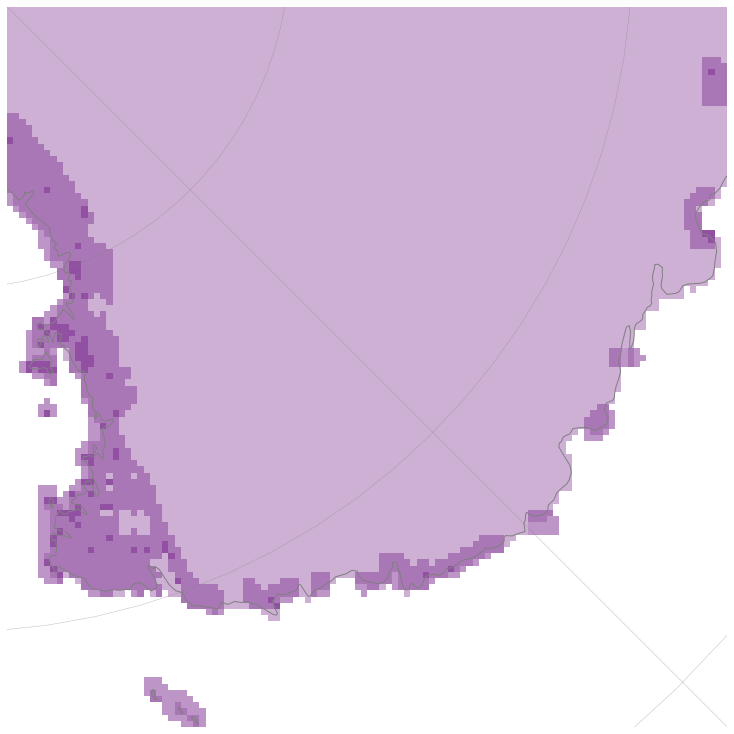

Saved to: fig/fig_4d.pdf


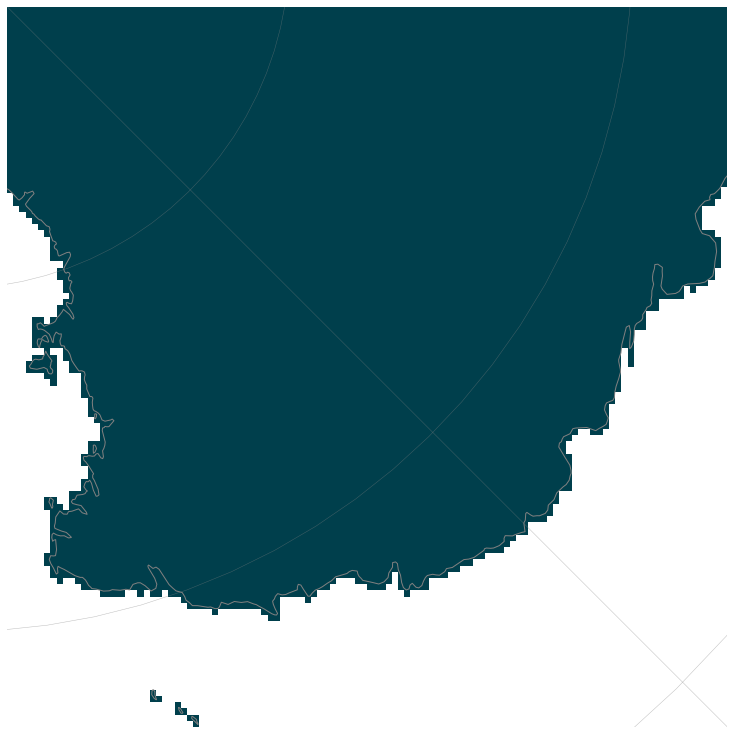

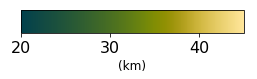

In [98]:
wsb.ds*=wsb.ds['WSB']

wsb.map_grid(['SCHAEFFER_CLASS','TINGEY_CLASS', 'GARD_CLASS'],
             save_name = 'fig/fig_4c.pdf', vmin = 0, vmax=4, cmap=geo_cmap, d_alpha = [0.45, 0.6, 1])




wsb.map_grid(wsb.ds['LAND']*(wsb.ds['AN_CRUST']+wsb.ds['BED'])/km,
             save_name = 'fig/fig_4d.pdf', vmin = 20, vmax=45, 
             cmap=SCM6.bamako, cfigsize = (4,4), save_cbar='fig/cbar/fig_4d.pdf', cbar_x_label='(km)')

Saved to: fig/fig_4_inset.pdf


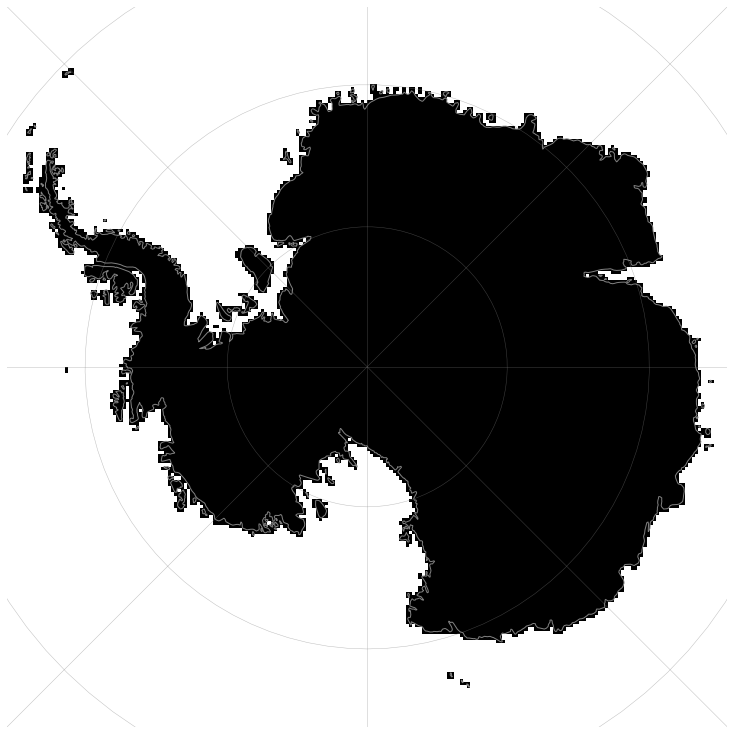

In [99]:
ant.ds['WSB'] *= ant.ds['LAND']

ant.map_grid('WSB', save_name='fig/fig_4_inset.pdf', cmap='bone', vmin=0, vmax=1.5)

In [100]:
ant.ds

<xarray.Dataset>
Dimensions:           (AK135_Z: 147, AN_TC_Z: 20, PMEAN_Z: 86, RGB: 3, RGBA: 4, SMEAN_Z: 58, X: 224, X_edge: 225, Y: 224, Y_edge: 225, Z: 51, Z_NEW: 14, Z_edge: 52)
Coordinates:
  * Z                 (Z) float64 0.0 2.5e+03 5e+03 ... 3e+05 3.25e+05 3.5e+05
  * X                 (X) float32 -2800000.0 -2774888.0 ... 2774888.0 2800000.0
  * Y                 (Y) float32 -2800000.0 -2774888.0 ... 2774888.0 2800000.0
  * X_edge            (X_edge) float32 -2812500.0 -2787388.5 ... 2812500.0
  * Y_edge            (Y_edge) float32 -2812500.0 -2787388.5 ... 2812500.0
  * Z_edge            (Z_edge) float64 -1.25e+03 1.25e+03 ... 3.625e+05
  * RGB               (RGB) <U1 'R' 'G' 'B'
    XV                (Y, X) float32 -2800000.0 -2774888.0 ... 2800000.0
    YV                (Y, X) float32 -2800000.0 -2800000.0 ... 2800000.0
    lat               (Y, X) float32 -54.67353 -54.822155 ... -54.67353
    lon               (Y, X) float32 -135.0 -135.25809 ... 44.741913 45.0
  * Z_NEW             (Z_NEW) int64 0 8000 16000 25000 ... 150000 200000 300000
  * SMEAN_Z           (SMEAN_Z) float64 2.5e+04 7.5e+04 ... 2.825e+06 2.875e+06
  * PMEAN_Z           (PMEAN_Z) int64 20000 40000 60000 ... 2750000 2800000
  * AN_TC_Z           (AN_TC_Z) float64 0.0 5e+03 1e+04 ... 9e+04 9.5e+04
  * AK135_Z           (AK135_Z) float64 nan nan 0.0 ... 6.32e+06 6.371e+06
Dimensions without coordinates: RGBA
Data variables:
    LAND              (Y, X) float64 nan nan nan nan nan ... nan nan nan nan nan
    BED               (Y, X) float64 nan nan nan nan nan ... nan nan nan nan nan
    SURFACE           (Y, X) float64 nan nan nan nan nan ... nan nan nan nan nan
    ICE               (Y, X) float64 nan nan nan nan nan ... nan nan nan nan nan
    PMEAN             (Y, X, PMEAN_Z) float64 nan nan nan nan ... nan nan nan
    SMEAN             (Y, X, SMEAN_Z) float64 nan nan nan nan ... nan nan nan
    PMEAN_I           (Y, X, Z_NEW) float64 nan nan nan nan ... nan nan nan nan
    SMEAN_I           (Y, X, Z_NEW) float64 nan nan nan nan ... nan nan nan nan
    AN_S1             (Y, X, Z) float64 nan nan nan nan nan ... nan nan nan nan
    AN_TS             (Y, X, Z) float64 nan nan nan nan nan ... nan nan nan nan
    AN_TC_T           (Y, X, AN_TC_Z) float64 nan nan nan nan ... nan nan nan
    AN_TC             (Y, X, Z) float64 nan nan nan nan nan ... nan nan nan nan
    AN_CRUST          (Y, X) float64 nan nan nan nan nan ... nan nan nan nan nan
    AN_T              (Y, X, Z) float64 nan nan nan nan nan ... nan nan nan nan
    DRAINAGE          (Y, X) float64 nan nan nan nan nan ... nan nan nan nan nan
    AFONSO_LITH_RHO   (Y, X) float64 nan nan nan nan nan ... nan nan nan nan nan
    AFONSO_CRUST_RHO  (Y, X) float64 nan nan nan nan nan ... nan nan nan nan nan
    TINGEY            (Y, X) float64 nan nan nan nan nan ... nan nan nan nan nan
    REG               (Y, X) float64 nan nan nan nan nan ... nan nan nan nan nan
    HF_FOX            (Y, X) float64 nan nan nan nan nan ... nan nan nan nan nan
    HF_MARTOS         (Y, X) float64 nan nan nan nan nan ... nan nan nan nan nan
    HF_AN             (Y, X) float64 nan nan nan nan nan ... nan nan nan nan nan
    CTD_MARTOS        (Y, X) float64 nan nan nan nan nan ... nan nan nan nan nan
    CTD_AN            (Y, X) float64 nan nan nan nan nan ... nan nan nan nan nan
    CTD_MARTOS_U      (Y, X) float64 nan nan nan nan nan ... nan nan nan nan nan
    HF_MARTOS_U       (Y, X) float64 nan nan nan nan nan ... nan nan nan nan nan
    OUTCROP           (Y, X) float64 nan nan nan nan nan ... nan nan nan nan nan
    LIEFFERINGE       (Y, X) float64 nan nan nan nan nan ... nan nan nan nan nan
    ADMAP2            (Y, X) float64 nan nan nan nan nan ... nan nan nan nan nan
    BOUGER            (Y, X) float64 nan nan nan nan nan ... nan nan nan nan nan
    AN_LAB            (Y, X) float64 nan nan nan nan nan ... nan nan nan nan nan
    WSB               (Y, X) float64 nan nan nan nan nan ... nan nan nan n

The merged crustal age datasets plotted: 

Saved to: fig/fig_3a.pdf


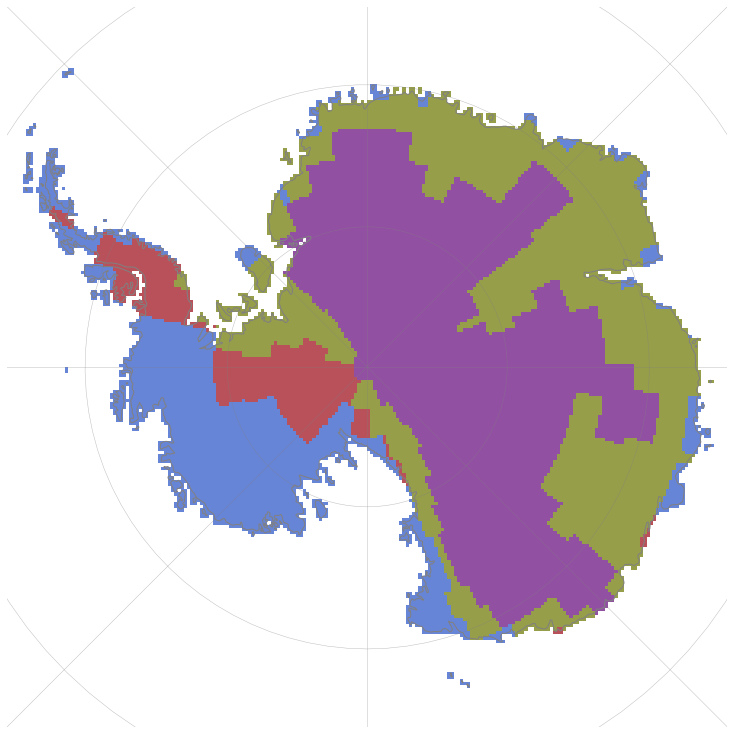

Saved to: fig/fig_3b.pdf


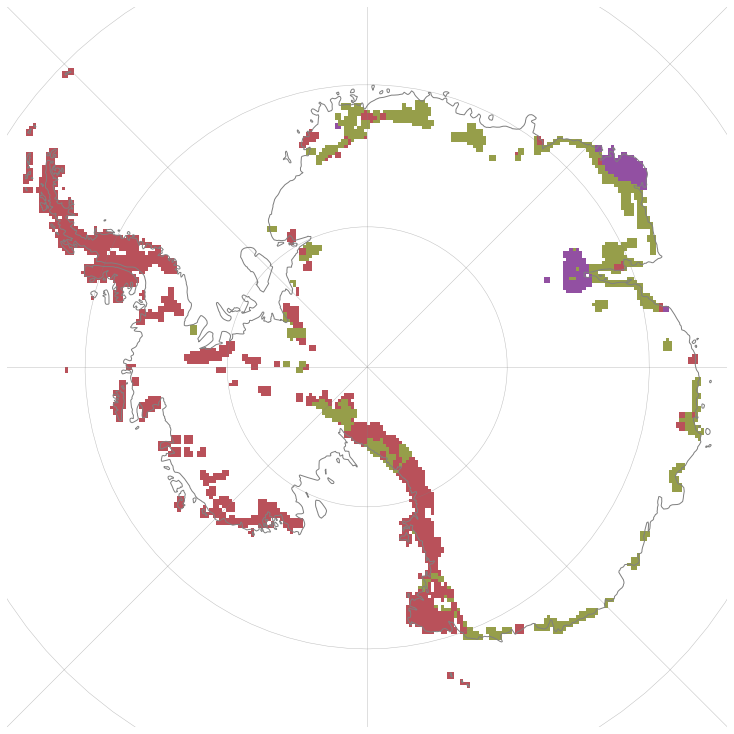

Saved to: fig/fig_3c.pdf


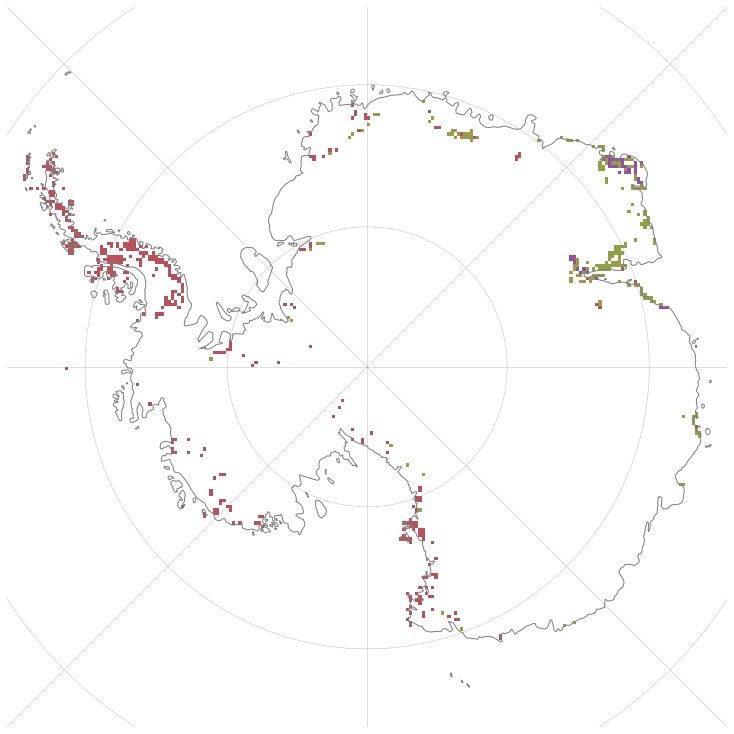

Saved to: fig/fig_3d.pdf


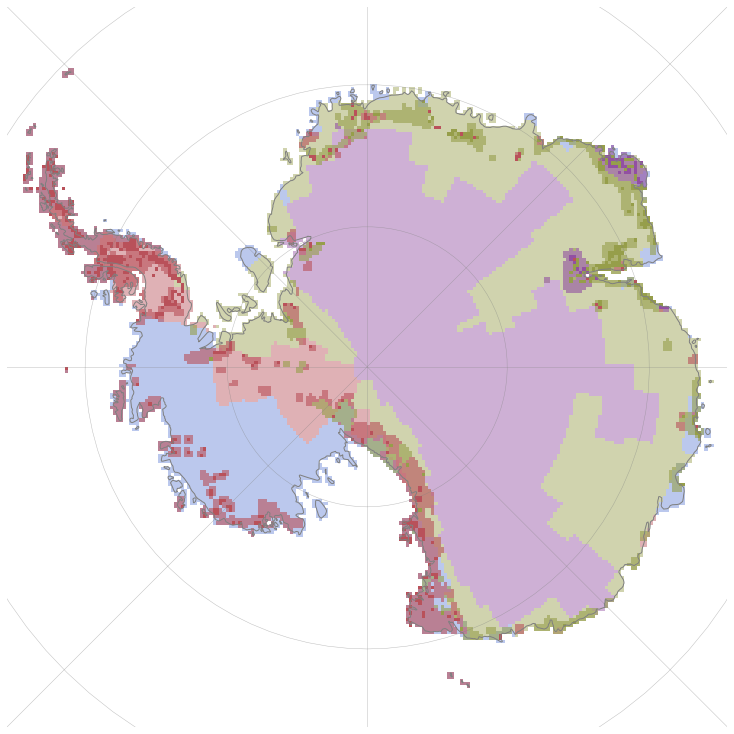

In [101]:
ant.map_grid('SCHAEFFER_CLASS', cmap=geo_cmap, vmin = 0, vmax=4, save_name='fig/fig_3a.pdf')
ant.map_grid('TINGEY_CLASS', cmap=geo_cmap, vmin = 0, vmax=4, save_name='fig/fig_3b.pdf')
ant.map_grid('GARD_CLASS', cmap=geo_cmap, vmin = 0, vmax=4, save_name='fig/fig_3c.pdf')
#ant.map_grid('GEO_CLASS', cmap=geo_cmap, vmin = 0, vmax=4, save_name='fig/fig_3d.pdf')

ant.map_grid(['SCHAEFFER_CLASS','TINGEY_CLASS', 'GARD_CLASS'],
             save_name = 'fig/fig_3d.pdf', vmin = 0, vmax=4, cmap=geo_cmap, d_alpha = [0.45, 0.6, 1])


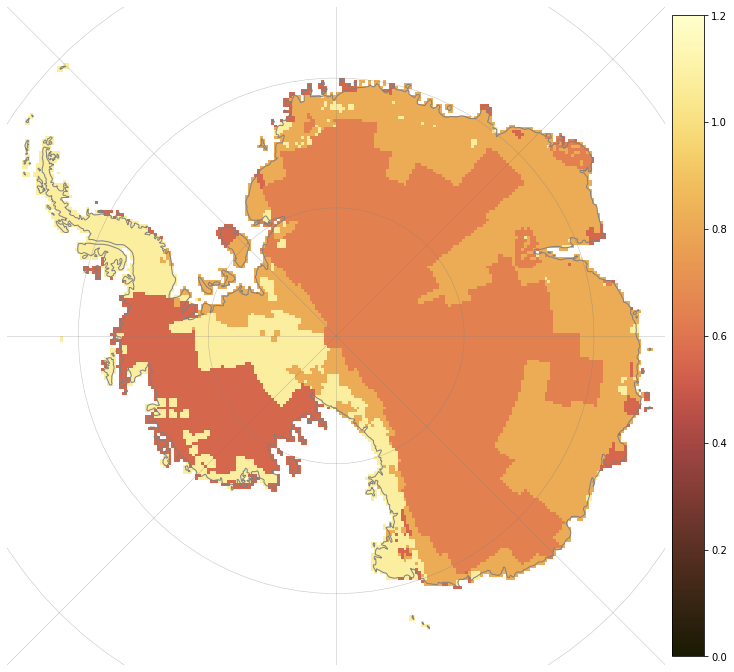

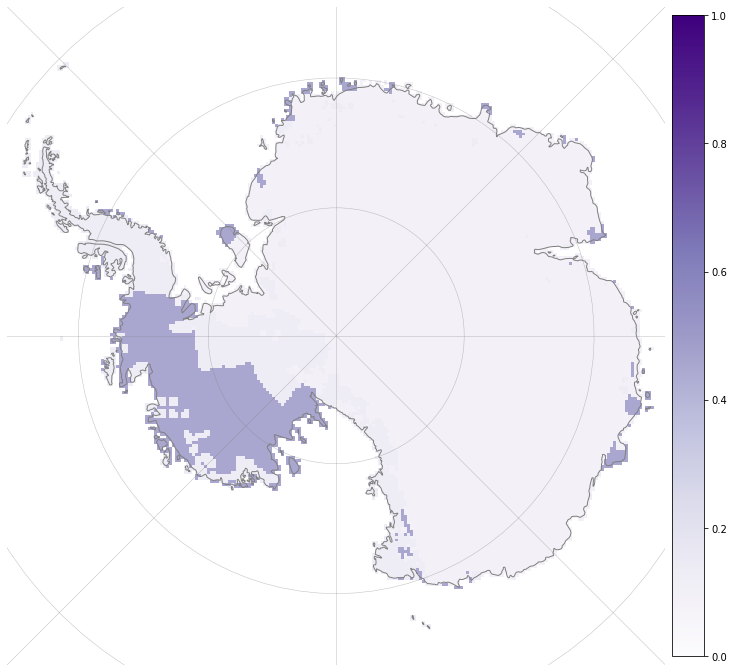

In [102]:
micro = 0.000001
A_Archean = (0.56*micro, 0.73*micro)
A_Proterozoic = (0.73*micro,0.90*micro)
A_Phanerozoic = (0.95*micro, 1.21*micro)
A_Ridges = (0.95*micro, 1.21*micro)
A_Oceanic = (0.1*micro, 0.8*micro) # Check Hasterok
A_Old_Oceanic = (0.1*micro, 1.*micro) # Check Hasterok
 
A_mean = dict([(0, np.mean(A_Archean)), 
           (1, np.mean(A_Proterozoic)),
           (2, np.mean(A_Phanerozoic)),
           (3, np.mean(A_Ridges)),
           (3, np.mean(A_Oceanic)),
           (3, np.mean(A_Old_Oceanic))])

   
A_e = dict([(0, np.std(A_Archean)), 
           (1, np.std(A_Proterozoic)),
           (2, np.std(A_Phanerozoic)),
           (3, np.std(A_Ridges)),
           (3, np.std(A_Oceanic)),
           (3, np.std(A_Old_Oceanic))])


for grid in [ant, wsb]:
    A = np.zeros(grid.nn)
    A[:] = np.nan
    
    for janse_class, A_class in A_mean.items():
        A[grid.ds['GEO_CLASS'] ==  janse_class] = A_class
    grid.ds['A_MEAN'] = (('Y', 'X'), A)
 
    A = np.zeros(grid.nn)
    A[:] = np.nan

    for janse_class, A_class in A_e.items():
        A[grid.ds['GEO_CLASS'] ==  janse_class] = A_class
        
    grid.ds['A_E'] = (('Y', 'X'), A)

    
ant.map_grid(ant.ds['A_MEAN']*1000000, cmap=SCM6.lajolla_r, vmin = 0, vmax = 1.2, cbar=1)
ant.map_grid(ant.ds['A_E']*1000000, cmap='Purples', vmin = 0, vmax = 1, cbar=1)

Make heatflow maps, AqSS

Saved to: fig/fig_5a.pdf


/Users/tobias_stal/anaconda3/lib/python3.7/site-packages/matplotlib/axis.py:1081: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "
/Users/tobias_stal/anaconda3/lib/python3.7/site-packages/matplotlib/axis.py:1091: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "


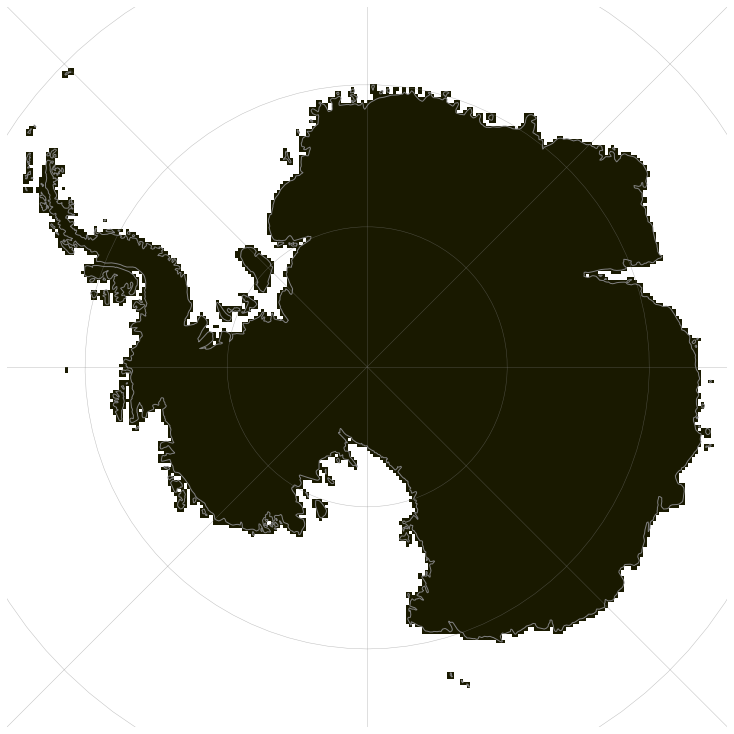

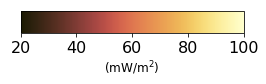

Saved to: fig/fig_5b.pdf


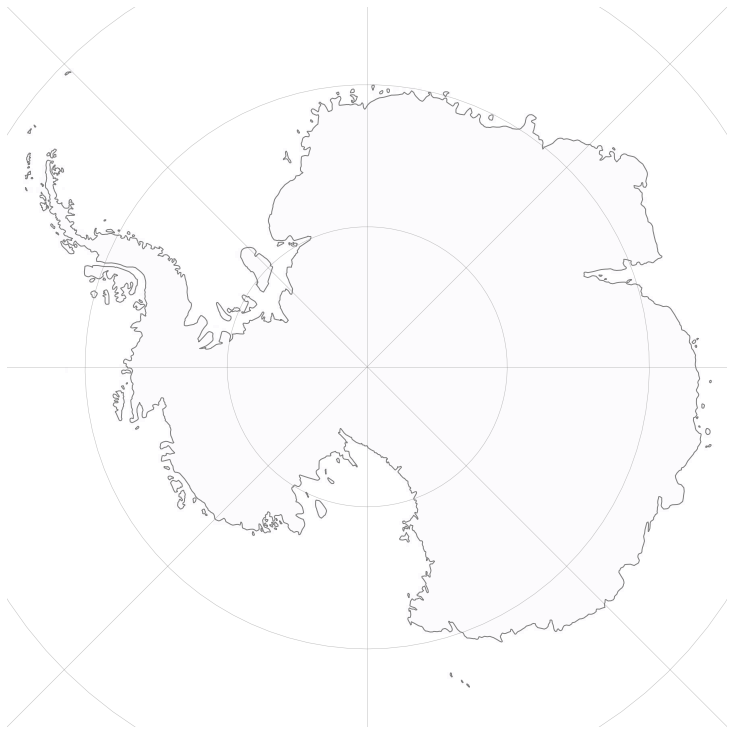

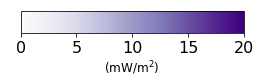

Saved to: fig/fig_5c.pdf


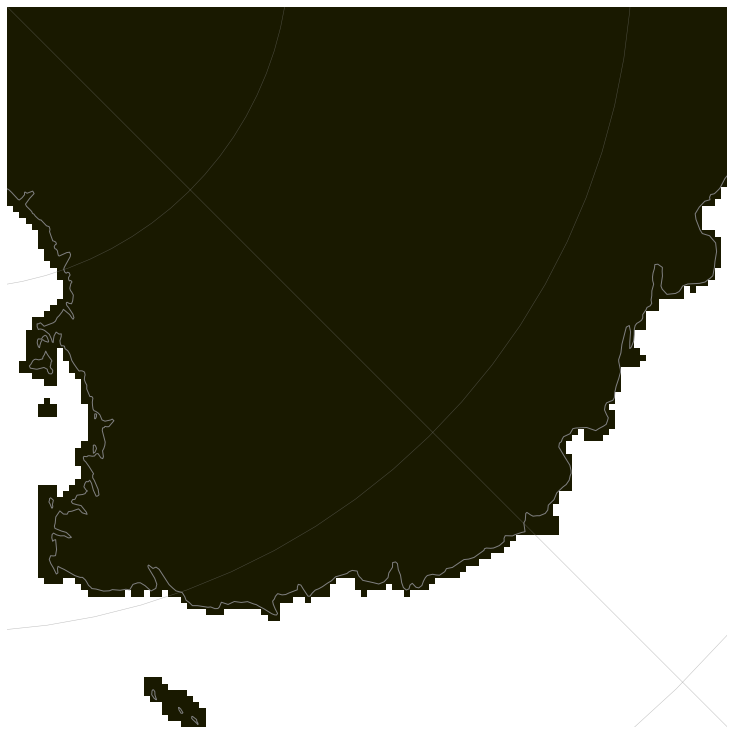

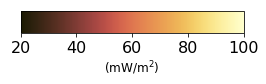

Saved to: fig/fig_5d.pdf


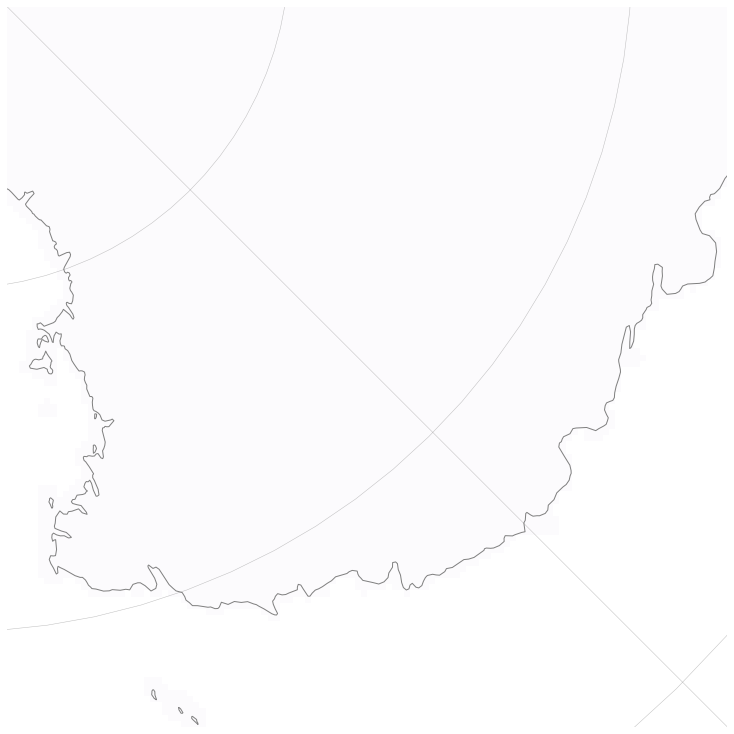

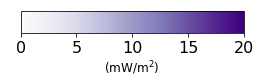

In [103]:
q_moho = 14*milli # Jaupart 2016
q_moho_e = 3*milli #Jaupart 2016

an_moho_e = 0.15 # 15% uncertainty ?!


q_cmap = SCM6.lajolla_r
q_u_cmap = 'Purples'
q_range_cbar = (20, 100)
q_u_range_cbar = (0, 20)



for grid in [ant, wsb]:
    d_m = grid.ds['AN_CRUST']+grid.ds['BED']
    e_a_tot = np.sqrt((grid.ds['A_E']/grid.ds['A_MEAN'])**2 + 0.15**2) * d_m*grid.ds['A_MEAN']

    e_q_tot = np.sqrt(e_a_tot**2 + q_moho_e**2)

    grid.ds['Q'] = q_moho + d_m * grid.ds['A_MEAN']
    grid.ds['Qe'] = e_q_tot

ant.map_grid(ant.ds['EAST'] * ant.ds['Q']/milli, cmap=q_cmap, save_name = 'fig/fig_5a.pdf', 
             vmin = q_range_cbar[0], vmax=q_range_cbar[1], cbar = 0, save_cbar='fig/cbar/fig_5a.pdf', cfigsize = (4,4), cbar_x_label='(mW/m$^2$)')


ant.map_grid(ant.ds['EAST'] * ant.ds['Qe']/milli, cmap=q_u_cmap, save_name = 'fig/fig_5b.pdf', 
            vmin = q_u_range_cbar[0], vmax=q_u_range_cbar[1], cbar = 0, save_cbar='fig/cbar/fig_5b.pdf', cbar_x_label='(mW/m$^2$)', cfigsize = (4,4))
    
    
wsb.map_grid(wsb.ds['WSB'] * wsb.ds['Q']/milli, cmap=q_cmap, save_name = 'fig/fig_5c.pdf', 
             vmin = q_range_cbar[0], vmax=q_range_cbar[1], cbar = 0, save_cbar='fig/cbar/fig_5c.pdf', cfigsize = (4,4), cbar_x_label='(mW/m$^2$)')


wsb.map_grid(wsb.ds['WSB'] * wsb.ds['Qe']/milli, cmap=q_u_cmap, save_name = 'fig/fig_5d.pdf', 
            vmin = q_u_range_cbar[0], vmax=q_u_range_cbar[1], cbar = 0, save_cbar='fig/cbar/fig_5d.pdf', cbar_x_label='(mW/m$^2$)', cfigsize = (4,4))
    

Saved to: fig/fig_6b.pdf


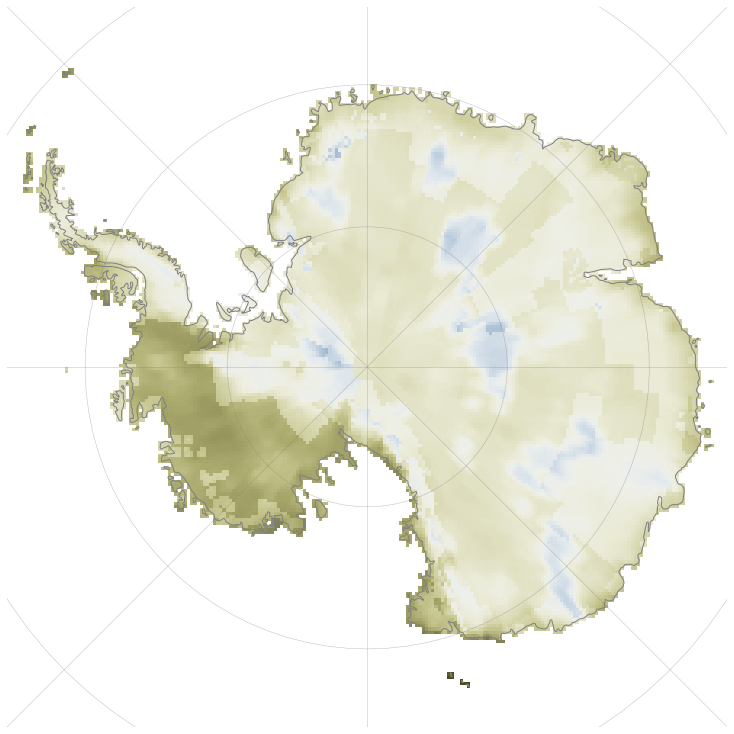

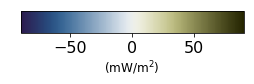

In [104]:
q_diff_range = (-90, 90)
q_diff_cbar = SCM6.broc


ant.map_grid((ant.ds['HF_AN'] - ant.ds['Q'])/milli, cmap=q_diff_cbar, save_name = 'fig/fig_6b.pdf', 
             vmin = q_diff_range[0], vmax=q_diff_range[1], save_cbar='fig/cbar/fig_6b.pdf', cfigsize = (4,4), cbar_x_label='(mW/m$^2$)')

Saved to: fig/fig_6c.pdf


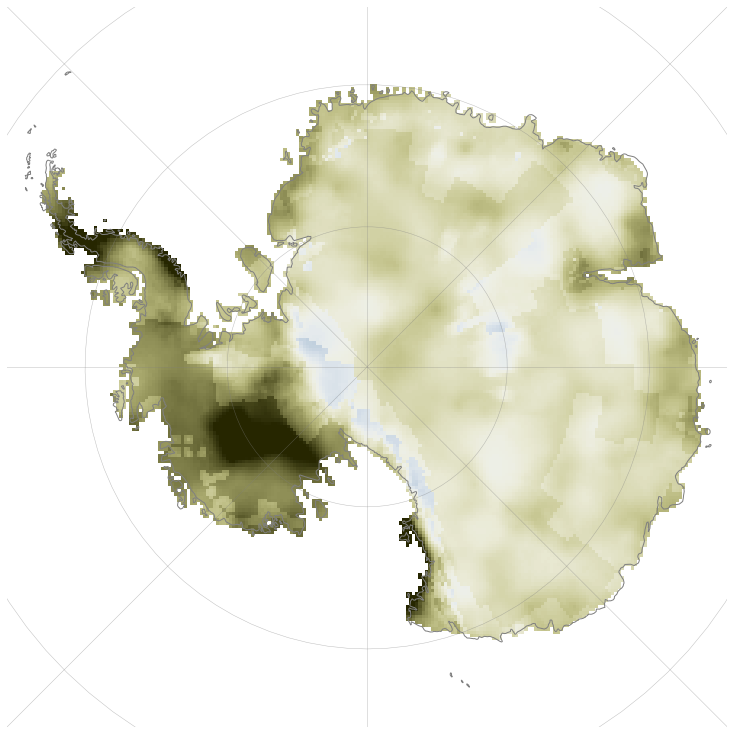

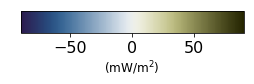

In [105]:
ant.map_grid((ant.ds['HF_MARTOS'] - ant.ds['Q'])/milli, cmap=q_diff_cbar, save_name = 'fig/fig_6c.pdf', 
             vmin = q_diff_range[0], vmax=q_diff_range[1], save_cbar='fig/cbar/fig_6c.pdf', cfigsize = (4,4), cbar_x_label='(mW/m$^2$)')

In [106]:
ant.grid_to_raster('Q', '../ggg/aq0.tiff')

CPLE_OpenFailedError: Attempt to create new tiff file '../ggg/aq0.tiff' failed: No such file or directory

In [ ]:
import matplotlib as mpl
fig = plt.figure(figsize=(15,15))
ax = fig.gca(projection='3d')

ant_10 = Grid(crs=3031, res = [100*km, 100*km], 
           extent=[-2800*km, 2800*km, -2800*km, 2800*km])


w=0.7

xpos=ant_10.ds['XV'].values.flatten('F')
ypos=ant_10.ds['YV'].values.flatten('F')

zpos = np.zeros_like(xpos) # Could be bedmap!

ant_range = [[ant_10.left, ant_10.right], [ant_10.down, ant_10.up]]
ant_bins=[ant_10.ds.coords['X_edge'], ant_10.ds.coords['Y_edge']]

count = stats.binned_statistic_2d(xi, yi, None, 'count', bins=ant_bins, range = ant_range)


zi = samples_df['A_AGE'].values

std = stats.binned_statistic_2d(xi, yi, zi, 'mean', bins=ant_bins, range = ant_range)

dx = ant.res[0]*w*10
dy = ant.res[1]*w*10
dz = count.statistic.flatten()
zpos[dz==0] = np.nan
dz[dz==0] = np.nan

stdz = std.statistic.flatten()



#Define colormap and get values for barcolors from it
cmap = plt.cm.Blues

vmin = np.nanmin(stdz)
vmax = np.nanmax(stdz)

norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
barcolors = plt.cm.ScalarMappable(norm, cmap)

ax.scatter(ant.ds['XV'].values.flatten(),
           ant.ds['YV'].values.flatten(),
           ant.ds['LAND'].values.flatten(), 
           c = 'orange', s=0.2)

print(np.nanmin(stdz), np.nanmax(stdz))




print(np.shape(mask), np.shape(xpos), np.shape(ypos), np.shape(zpos), np.shape(dx), np.shape(dy), np.shape(dz))

ax.bar3d(xpos, ypos, zpos, 
         dx, dy, dz, 
         zsort='average',
         alpha=0.4, 
         linewidth=0.5) 

ax.set_zlim(0, 300)
ax.azim = 250
ax.elev = 45
ax.dist = 10

ax.set_xlabel('X', fontsize=12)
ax.set_ylabel('Y', fontsize=12)
ax.set_zlabel('N', fontsize=12)

ax.set_rasterized(True)

fig.savefig('fig/fig_s1.pdf', transparent=True,dpi=300,
                        bbox_inches='tight', pad_inches=0)


In [ ]:
try:
    heat_all = pd.read_csv(data_path + '/thermo_globe/ThermoGlobe_21_10_19.csv', 
                         encoding = 'ISO-8859-1',
                         low_memory=False)

    # We are also only interested in records that contains some info that we can use for heat estimates
    needed_data = ['heatflow_corrected','latitude','longitude']
    heat_df = heat_all.dropna(subset=needed_data, how='all')
except:
    print('# Download from http://www.heatflow.org/thermoglobe/map#')

In [ ]:
heat_df   

In [ ]:
# For now, we can drop some columns 
drop_columns = ['site_name',
 'elevation',
 'dip',
 'well_depth',
 'sediment_thickness',
 'basin',
 'sub_basin',
 'domain',
 'province',
 'tectonic_environment',
 'bottom_hole_temp',
 'top_hole_temp',
 'depth_min',
 'depth_max',
 'age_min',
 'age_max',
 'age_method',
 'heatflow_reliability',
 'heatflow_uncorrected',
 'heatflow_uncorrected_uncertainty',
 'gradient_corrected',
 'gradient_corrected_uncertainty',
 'gradient_uncorrected',
 'gradient_uncorrected_uncertainty',
 'thermal_conductivity',
 'conductivity_uncertainty',
 'conductivity__number_of_measurementsy',
 'conductivity__method',
 'heatgeneration__value',
 'heatgeneration__uncertainty',
 'heatgeneration__number_of_measurements',
 'heatgeneration__method',
 'author',
 'year',
 'doi',
 'operator',
 'cruise',
 'comment']
heat_df = heat_df.drop(drop_columns, axis=1)

In [ ]:
A = stats.binned_statistic_2d(yi, xi, 
                                samples_df['AGE'], 
                                statistic='mean', 
                                bins=ant.nn, 
                                range= [[ant.left, ant.right], [ant.down, ant.up]], 
                                expand_binnumbers=False)


# Remove samples claimed to be from bins that are not outcrops
geo_bins = np.logical_and(np.isfinite(A[0]),ant.ds['OUTCROP'].values)


x_pos = ant.ds['XV'].values[geo_bins]
y_pos = ant.ds['YV'].values[geo_bins]
val = A[0][geo_bins]

ant.ds['age'] = (('Y', 'X') ,interpolate.griddata((y_pos, x_pos),val,(ant.ds.coords['YV'], 
                                    ant.ds.coords['XV']), 
                                    method='nearest') )



In [ ]:
heat_aus_df = heat_df[heat_df['latitude'].between(-44, -10)]
heat_aus_df = heat_aus_df[heat_aus_df['longitude'].between(113, 154)]

aus_proj = 3577

qi = heat_aus_df['heatflow_corrected'].values

import pyproj as proj
xi, yi = proj.transform(proj.Proj('+init=epsg:4326'),
                                proj.Proj('+init=epsg:3577'), 
                        heat_aus_df['longitude'].values, heat_aus_df['latitude'].values)



yi = yi[np.isfinite(qi)]
xi = xi[np.isfinite(qi)]

qi = qi[np.isfinite(qi)]

In [ ]:
aus = Grid(crs=3577, res = [40*km, 40*km], 
           extent=[-2000*km, 2200*km, -5000*km, -1100*km])

aus.ds['Q'] = (('Y', 'X') ,interpolate.griddata((yi, xi),qi,(aus.ds.coords['YV'], 
                                    aus.ds.coords['XV']), 
                                    method='linear') )

aus.ds['LAND'] = (('Y', 'X'), aus.assign_shape(data_path + '/NE/ne_10m_land.shp', 
                                               'scalerank', map_to_int = False, burn_val = 1))

In [ ]:
aus.ds['Q'] *= aus.ds['LAND']

plt.imshow(aus.ds['Q'], origin='lower')

In [ ]:
plt.plot(heat_aus_df['longitude'], heat_aus_df['latitude'], '.')

In [ ]:

hf_names = ['HF_FOX', 'HF_AN', 'HF_MARTOS', 'Q', 'AUS_HF']
hf_labels = ['Maule 2005', 'An 2015', 'Martos 2017', 'This study \nmin and max', 'Australia \nHasterok 2019 '] 



fig, ax = plt.subplots(5,1, figsize=(12,8), sharex=True)

font = {
        'size': 12,
        }



x_min_q = 0
x_max_q = 120


def plot_q(dist, i,color='k', data_label = None):
    if data_label is None:
        data_label = hf_labels[i]
    
    dist = dist.values.flatten()
    dist = dist[np.isfinite(dist)]
    q_avg = np.mean(dist)
    q_median = np.median(dist)
    q_min = np.percentile(dist, 5)
    q_max = np.percentile(dist, 95)
    ax[i].axvline(q_avg, c='brown', alpha=0.6, label= 'Mean')
    ax[i].axvline(q_median, c='green', alpha=0.6, label='Median')
    
    #ax[i].axvline(q_min, c='orange', alpha=0.6, label='5% percentiles')
    #ax[i].axvline(q_max, c='orange', alpha=0.6)
    

    

    density = gaussian_kde(dist)
    xs = np.linspace(x_min_q, x_max_q, 500)
    density.covariance_factor = lambda : .2
    density._compute_covariance()
    ys = density(xs)
    ax[i].plot(xs,ys/ys.max())

    
    
    
    
    #n, x, _ = ax[i].hist(dist, bins=np.linspace(x_min_q, x_max_q, 500), 
    #               histtype=u'step', density=True, color = 'k') 
    ax[i].set_xlim((x_min_q,x_max_q))
    ax[i].text(x_min_q+1,0.5,data_label, fontdict = font)
    ax[i].get_yaxis().set_ticks([])
    return None


for hf_name, hf_label, i in zip(hf_names, hf_labels, range(0,3)):
    dist = 1000 * ant.ds[hf_name].where(ant.ds['EAST'])
    plot_q(dist, i)
    

    
    
dist = 1000 * (ant.ds['Q']-ant.ds['Qe']).where(ant.ds['EAST'])
plot_q(dist, 3, color='b')

dist = 1000 * (ant.ds['Q']+ant.ds['Qe']).where(ant.ds['EAST'])
plot_q(dist, 3, color='r', data_label='')    

    
dist = aus.ds['Q']
plot_q(dist, 4)

    
ax[0].legend(prop = font)
ax[4].set_xlabel('mW/m2')


plt.savefig('fig/fig_6a.pdf')
plt.show()



Make profiles of East and West Antarctica:

In [ ]:
ant.ds['WEST'] =  1 - ant.ds['EAST']
 

T = np.copy(ant.ds['AN_TS'].values)
z = - np.copy(ant.ds['Z'].values)

z = np.broadcast_to(z, np.shape(T))

mask = np.isnan(T)

z = z[~mask]
T = T[~mask]



In [ ]:

ant.ds['WEST'] = ant.ds['LAND'] - ant.ds['EAST'].fillna(0)
ant.ds['WEST'] = ant.ds['WEST'].where(ant.ds['WEST']==1, np.nan)
print(ant.ds['WEST'])

ant.map_grid('WEST', save_name='fig/fig_7a_inset.pdf', cmap='bone', vmin=0, vmax=1.5)
ant.map_grid('EAST', save_name='fig/fig_7b_inset.pdf', cmap='bone', vmin=0, vmax=1.5)

In [ ]:

#(lon, lat), 
west_loc = (-153.50, -84.25)
east_loc = (123.33, -75.10)

print(np.shape(west_loc))

z = - np.copy(ant.ds['Z'].values)
z = np.broadcast_to(z, np.shape(ant.ds['AN_TS']))

CT = 580

levels = 6

step = 5


for i, (region, loc)  in enumerate(zip(['WEST', 'EAST'], [west_loc, east_loc])):
    fig, ax = plt.subplots(1,1, figsize=(5,7))
        
    T_reg = (ant.ds['AN_TS']*ant.ds[region]).values
    mask = np.isnan(T_reg)
    z_reg = z[~mask].ravel()[::step]
    T_reg = T_reg[~mask].ravel()[::step]
                            
    CTD_reg = - (ant.ds['CTD_MARTOS']*ant.ds[region]).values
    mask = np.isnan(CTD_reg)
    CTD_reg = CTD_reg[~mask].ravel()[::step]
    CTD_T = np.ones(np.shape(CTD_reg))*CT
    
    CTD_reg_upper = - ((ant.ds['CTD_MARTOS']+ ant.ds['CTD_MARTOS_U'])*ant.ds[region]).values
    CTD_reg_upper = CTD_reg_upper[~mask].ravel()[::step]
    
    
    
    CTD_reg_lower = - ((ant.ds['CTD_MARTOS']- ant.ds['CTD_MARTOS_U'])*ant.ds[region]).values
    CTD_reg_lower = CTD_reg_lower[~mask].ravel()[::step]

    
    T_bed = (ant.ds['LIEFFERINGE']*ant.ds[region]).values
    z_bed = (ant.ds['BED']*ant.ds[region]).values
    
    T_bed = T_bed.ravel()
    z_bed = z_bed.ravel()
    
    mask = np.logical_or(np.isnan(T_bed), np.isnan(z_bed))

    T_bed = T_bed[~mask]
    z_bed = z_bed[~mask]

    x_sample, y_sample = proj.transform(proj.Proj('+init=epsg:4326'),
                                proj.Proj('+init=epsg:3031'), 
                        loc[0], loc[1])
    loc_x = ant.ds['AN_TS'].sel(X=x_sample, Y=x_sample, method='nearest').values[::-1]
    loc_y = ant.ds['Z'].values[::-1]
          
    mask = np.isnan(loc_x)
    loc_x = np.append(loc_x[~mask], [CT])
    loc_y = np.append(loc_y[~mask], [ant.ds['CTD_MARTOS'].sel(X=x_sample, Y=y_sample, method='nearest').values])
    
    loc_x = np.append(loc_x, [ant.ds['LIEFFERINGE'].sel(X=x_sample, Y=y_sample, method='nearest').values])
    loc_y = np.append(loc_y, [ant.ds['BED'].sel(X=x_sample, Y=y_sample, method='nearest').values])
    
    
    ew = 'E'
    if loc[0] <0:
        ew='W'
    
    
    sns.kdeplot(T_bed[::step], z_bed[::step]/km, ax=ax, 
                bw=(5,0.1),shade_lowest=False, cmap=plt.cm.Reds, levels=levels)
    
    
    sns.kdeplot(CTD_T, CTD_reg_upper/km, ax=ax, bw=(25,5),
                shade_lowest=False, cmap=plt.cm.Greens, levels=levels)
    
    
    sns.kdeplot(CTD_T, CTD_reg_lower/km, ax=ax, bw=(25,5),
                shade_lowest=False, cmap=plt.cm.Greens, levels=levels)
    

    
    # Seis
    sns.kdeplot(T_reg, z_reg/km, ax=ax,shade_lowest=False, 
                bw=(100,10), cmap=plt.cm.gray_r, levels=levels)
    
    
    ax.set_xlabel('$^\circ$C')
    
    ax.plot(loc_x, -loc_y/km, 'brown', label = '%s$^\circ$S, %s$^\circ$%s'%(abs(loc[1]), abs(loc[0]), ew))
    ax.set_ylabel('(km)')
    ax.legend()
    
    ax.set_ylim((-250, 10))
    ax.set_xlim((-50, 2000))
    
    plt.savefig('fig/fig_7%s.pdf'%'ab'[i])
    plt.show()   

The model can be saved as netCDF, but the file is rather large. 

In [ ]:
ant.ds.to_netcdf('ant.nc') # Save model as netCDF

! stat -f%z ant.nc

We also use agrid functionality to export raster files. 

In [ ]:
ant.grid_to_raster('BEDMAP_I', 'ant_gia_dem_0.tiff')
ant.grid_to_raster('Q', 'AqSS.tiff')

Next cell runs a shell commant to compile subfigures to figures using TikZ and copy generated figures to the manuscript directory. 

In [ ]:
! mkdir -p final
!(cd fig/ && latexmk -pdf && rsync -avhP fig_1.pdf fig_2.pdf fig_3.pdf fig_4.pdf fig_5.pdf fig_6.pdf fig_7.pdf fig_s1.pdf fig_s2.pdf fig_s3.pdf fig_s4.pdf quick_guide.pdf final/)